In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"triikas","key":"f14377df34f4e726878188c3afc64058"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d shanegerami/ai-vs-human-text

Dataset URL: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text
License(s): other


In [ ]:
import shutil
shutil.unpack_archive("/content/ai-vs-human-text.zip",
                      "/content/ai-vs-human-text")

In [ ]:
datadir='/content/ai-vs-human-text'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

import pandas as pd
import numpy as np
from collections import Counter
import string
import random
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import matthews_corrcoef, classification_report

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv('/content/ai-vs-human-text/AI_Human.csv')
df.head()

text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0

In [ ]:
df_zero = df[df['generated'] == 0]
df_one = df[df['generated'] == 1]

df_zero_sampled = df_zero.sample(10000)
df_one_sampled = df_one.sample(10000)

df = pd.concat([df_zero_sampled, df_one_sampled])
df.reset_index(inplace=True)
print(f'Number of rows: {len(df)}')

Number of rows: 20000


In [ ]:
df.loc[18, 'text']

'"Driverless Cars Are Coming" article presents many aspects, both positive Ana negative, about these cars. Some positives are the cars are foreseen to use half of the fuel today\'s cars use, offer more flexibility than a bus, Ana people would not have to buy cars anymore. I personally believe that this is a baa Ana possibly dangerous IAEA. Driverless cars have no laws regarding them Ana are Hara to decide who is liable, Ana the cars are not very well evolved yet.\n\nFirstly, the law aspect of Driverless Cars is the majority of the time nonexistent. An exception to the previous statement is that these cars are illegal even to test on roads in most state making it very obvious there has been little real life testing. So no laws are in place to prepare for the new problems that will arise when these cars are actually in use Ana on the roads. If the technology fails Ana someone is injured who is at fault? Or if there is property damage? Should the car manufacturer or the river be at blame 

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

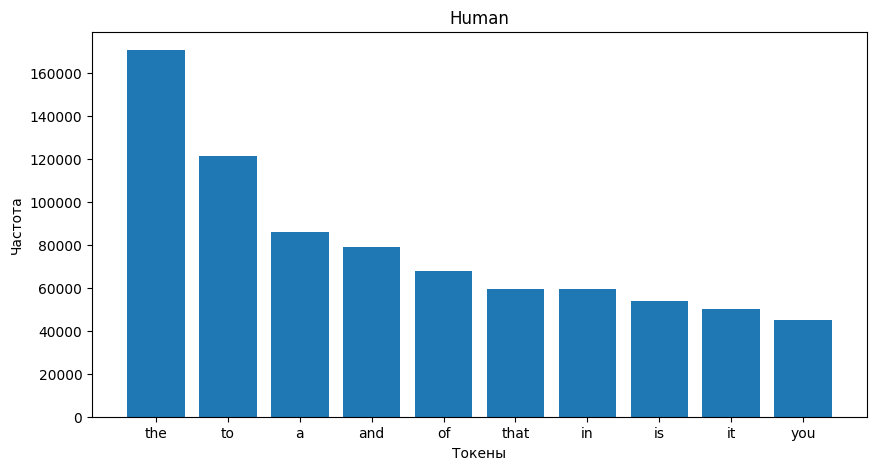

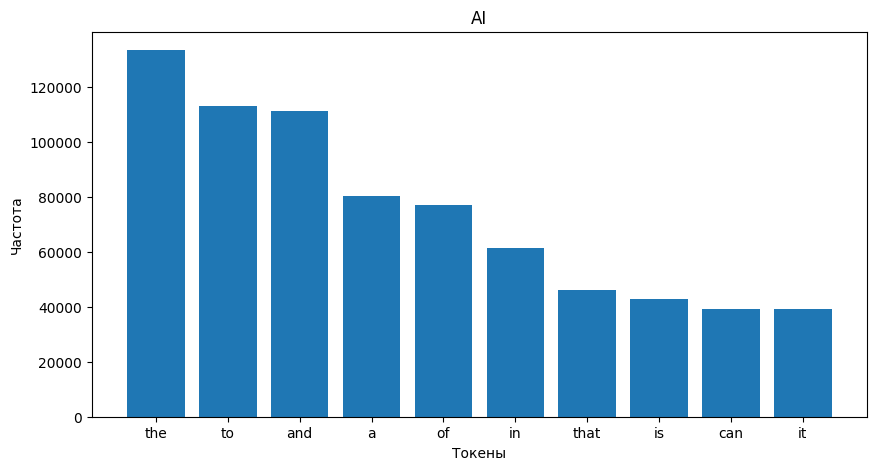

In [ ]:
df_visualization = df.copy()

max_length = tokenizer.model_max_length

def tokenize_and_truncate(text, max_length):
    tokens = tokenizer.tokenize(text)
    return tokens[:max_length]

df_visualization['tokens'] = df_visualization['text'].apply(lambda x: tokenize_and_truncate(x, max_length))

def token_plot(df, class_value):
    df_class = df[df['generated'] == class_value]
    class_map = {0: 'Human', 1: 'AI'}

    token_freq = Counter(token for tokens in df_class['tokens'] for token in tokens if token not in string.punctuation)

    common_tokens = token_freq.most_common(10)
    tokens, counts = zip(*common_tokens)

    plt.figure(figsize=(10, 5))
    plt.bar(tokens, counts)
    plt.title(f'{class_map[class_value]}')
    plt.xlabel('Токены')
    plt.ylabel('Частота')
    plt.show()


token_plot(df_visualization, 0)
token_plot(df_visualization, 1)

In [ ]:
class Ds(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.ids = []
        self.text_lengths = []
        self.classes = [0, 1]
        self.targets = torch.tensor(df.generated, dtype=torch.long)

        for text in df.text:
            inputs = tokenizer.encode_plus(
                text,
                None,
                add_special_tokens=True,
                max_length=max_len,
                padding='max_length',
                truncation=True,
                return_token_type_ids=True
            )

            ids = inputs['input_ids']


            # считаем длину текста без паддингов
            length = len([t for t in ids if t != tokenizer.pad_token_id])

            self.ids.append(torch.tensor(ids, dtype=torch.long))

            self.text_lengths.append(length)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return [self.ids[idx], self.text_lengths[idx]], self.targets[idx]

In [ ]:
max_length = tokenizer.model_max_length

dataset = Ds(df, tokenizer, max_length)

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [17000, 3000])

In [ ]:
batch_size=64

In [ ]:
# def collate_fn(batch):
#     inputs, targets = zip(*batch)

#     input_ids = [item[0] for item in inputs]  # уже тензоры
#     lengths = [item[1] for item in inputs]    # обычные числа

#     padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
#     lengths = torch.tensor(lengths)
#     targets = torch.stack(targets)

#     return (padded_input_ids, lengths), targets

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)#, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)#, collate_fn=collate_fn)

In [ ]:
'''RNN 1 a'''

class RNN1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(RNN1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed_embedded)

        dropout = self.dropout(hidden.squeeze(0))

        out = self.fc(dropout)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = RNN1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

RNN1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (rnn): RNN(128, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
'''RNN 1 b'''

class RNN1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(RNN1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed_embedded)

        dropout = self.dropout(hidden.squeeze(0))

        out = self.fc(dropout)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = RNN1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=32,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

RNN1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (rnn): RNN(128, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
'''RNN 1 с'''

class RNN1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(RNN1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed_embedded)

        dropout = self.dropout(hidden.squeeze(0))

        out = self.fc(dropout)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = RNN1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=256,
    hidden_dim=128,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

RNN1(
  (embedding): Embedding(30522, 256, padding_idx=0)
  (rnn): RNN(256, 128, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
'''RNN 2 a'''

class RNN2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(RNN2, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, num_layers=2, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim*2, 64)
        self.fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed_embedded)

        hidden_forward = hidden[-2,:,:]
        hidden_backward = hidden[-1,:,:]
        hidden = torch.cat((hidden_forward, hidden_backward), dim=1)  # [batch, hidden_dim*2]
        dropout = self.dropout(hidden)

        fc = self.fc(dropout)
        fc2 = self.fc2(fc)
        dropout2 = self.dropout2(fc)
        out = self.fc3(fc)
        return out



model = RNN2(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

RNN2(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (rnn): RNN(128, 64, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=64, bias=True)
  (fc2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
'''RNN 2 b'''

class RNN2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(RNN2, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, num_layers=3, bidirectional=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_dim*2, 64)
        self.fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed_embedded)

        hidden_forward = hidden[-2,:,:]
        hidden_backward = hidden[-1,:,:]
        hidden = torch.cat((hidden_forward, hidden_backward), dim=1)  # [batch, hidden_dim*2]
        dropout = self.dropout(hidden)

        fc = self.fc(dropout)
        fc2 = self.fc2(fc)
        dropout2 = self.dropout2(fc)
        out = self.fc3(fc)
        return out



model = RNN2(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

RNN2(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (rnn): RNN(128, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=128, out_features=64, bias=True)
  (fc2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
'''RNN 2 c'''

class RNN2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(RNN2, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, num_layers=3, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim*2, 64)
        self.fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(packed_embedded)

        hidden_forward = hidden[-2,:,:]
        hidden_backward = hidden[-1,:,:]
        hidden = torch.cat((hidden_forward, hidden_backward), dim=1)  # [batch, hidden_dim*2]
        dropout = self.dropout(hidden)

        fc = self.fc(dropout)
        fc2 = self.fc2(fc)
        dropout2 = self.dropout2(fc)
        out = self.fc3(fc)
        return out



model = RNN2(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

RNN2(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (rnn): RNN(128, 64, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=64, bias=True)
  (fc2): ReLU()
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
'''LSTM 1 a'''

class LSTM1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(LSTM1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)
        hidden = hidden[-1]

        dropout = self.dropout(hidden)

        out = self.fc(dropout)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = LSTM1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=32,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

LSTM1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): LSTM(128, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
'''LSTM 1 b'''

class LSTM1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(LSTM1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)
        hidden = hidden[-1]

        dropout = self.dropout(hidden)

        out = self.fc(dropout)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = LSTM1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

LSTM1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
'''LSTM 1 c'''

class LSTM1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(LSTM1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)
        hidden = hidden[-1]

        dropout = self.dropout(hidden)

        out = self.fc(dropout)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = LSTM1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

LSTM1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
'''LSTM 2 a'''

class LSTM1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(LSTM1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.7)
        # self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(hidden_dim*2, 64)
        self.fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(64, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)

        # скрытые состояния для forward и backward слоёв (последний слой LSTM)
        hidden_forward = hidden[-2, :, :]  # (batch, hidden_dim)
        hidden_backward = hidden[-1, :, :] # (batch, hidden_dim)
        hidden = torch.cat((hidden_forward, hidden_backward), dim=1)  # (batch, hidden_dim*2)

        dropout = self.dropout(hidden)
        fc = self.fc(dropout)
        fc2 = self.fc2(fc)
        dropout2 = self.dropout2(fc2)
        out = self.fc3(dropout2)

        return out


model = LSTM1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

LSTM1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=128, out_features=64, bias=True)
  (fc2): ReLU()
  (dropout2): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
'''LSTM 2 b'''

class LSTM1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(LSTM1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.dropout = nn.Dropout(0.7)
        # self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(0.8)
        self.fc = nn.Linear(hidden_dim*2, 32)
        self.fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.7)
        self.fc3 = nn.Linear(32, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)

        # скрытые состояния для forward и backward слоёв (последний слой LSTM)
        hidden_forward = hidden[-2, :, :]  # (batch, hidden_dim)
        hidden_backward = hidden[-1, :, :] # (batch, hidden_dim)
        hidden = torch.cat((hidden_forward, hidden_backward), dim=1)  # (batch, hidden_dim*2)

        dropout = self.dropout(hidden)
        fc = self.fc(dropout)
        fc2 = self.fc2(fc)
        dropout2 = self.dropout2(fc2)
        out = self.fc3(dropout2)

        return out


model = LSTM1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

LSTM1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=128, out_features=32, bias=True)
  (fc2): ReLU()
  (dropout2): Dropout(p=0.7, inplace=False)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
'''LSTM 2 c'''

class LSTM1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(LSTM1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.dropout = nn.Dropout(0.7)
        # self.fc = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(0.8)
        self.fc = nn.Linear(hidden_dim*2, 32)
        self.fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.8)
        self.fc3 = nn.Linear(32, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded)

        # скрытые состояния для forward и backward слоёв (последний слой LSTM)
        hidden_forward = hidden[-2, :, :]  # (batch, hidden_dim)
        hidden_backward = hidden[-1, :, :] # (batch, hidden_dim)
        hidden = torch.cat((hidden_forward, hidden_backward), dim=1)  # (batch, hidden_dim*2)

        dropout = self.dropout(hidden)
        fc = self.fc(dropout)
        fc2 = self.fc2(fc)
        dropout2 = self.dropout2(fc2)
        out = self.fc3(dropout2)

        return out


model = LSTM1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=32,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

LSTM1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): LSTM(128, 32, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (fc2): ReLU()
  (dropout2): Dropout(p=0.8, inplace=False)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
'''GRU 1 a'''

class GRU1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(GRU1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.lstm(packed_embedded)
        hidden = hidden[-1]

        dropout = self.dropout(hidden)

        out = self.fc(dropout)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = GRU1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=32,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

GRU1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): GRU(128, 32, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
'''GRU 1 b'''

class GRU1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(GRU1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.6)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.lstm(packed_embedded)
        hidden = hidden[-1]

        dropout = self.dropout(hidden)

        out = self.fc(dropout)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = GRU1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

GRU1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): GRU(128, 64, batch_first=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
'''GRU 1 c'''

class GRU1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(GRU1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.lstm(packed_embedded)
        hidden = hidden[-1]

        dropout = self.dropout(hidden)

        out = self.fc(dropout)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = GRU1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

GRU1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): GRU(128, 64, batch_first=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
'''GRU 2 a'''

class GRU1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(GRU1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.7)
        self.fc3 = nn.Linear(32, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.lstm(packed_embedded)
        hidden = hidden[-1]

        dropout = self.dropout(hidden)
        fc = self.fc(dropout)
        fc2 = self.fc2(fc)
        dropout2 = self.dropout2(fc2)
        out = self.fc3(dropout2)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = GRU1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

GRU1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): GRU(128, 64, batch_first=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (fc2): ReLU()
  (dropout2): Dropout(p=0.7, inplace=False)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
'''GRU 2 b'''

class GRU1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(GRU1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.8)
        self.fc = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.7)
        self.fc3 = nn.Linear(32, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.lstm(packed_embedded)
        hidden = hidden[-1]

        dropout = self.dropout(hidden)
        fc = self.fc(dropout)
        fc2 = self.fc2(fc)
        dropout2 = self.dropout2(fc2)
        out = self.fc3(dropout2)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = GRU1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=32,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

GRU1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): GRU(128, 32, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (fc2): ReLU()
  (dropout2): Dropout(p=0.7, inplace=False)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
'''GRU 2 c'''

class GRU1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(GRU1, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.8)
        self.fc = nn.Linear(hidden_dim, 16)
        self.fc2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.7)
        self.fc3 = nn.Linear(16, output_dim)


    def forward(self, input):
        input_ids = input[0]
        lengths = input[1]
        embedded = self.embedding(input_ids)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.lstm(packed_embedded)
        hidden = hidden[-1]

        dropout = self.dropout(hidden)
        fc = self.fc(dropout)
        fc2 = self.fc2(fc)
        dropout2 = self.dropout2(fc2)
        out = self.fc3(dropout2)
        return out
        # return out.squeeze(1)
        # return torch.sigmoid(out)


model = GRU1(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=128,
    hidden_dim=32,
    output_dim=2,
    pad_idx=tokenizer.pad_token_id
)
model.to(device)

GRU1(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (lstm): GRU(128, 32, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=32, out_features=16, bias=True)
  (fc2): ReLU()
  (dropout2): Dropout(p=0.7, inplace=False)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
optimizer = optim.Adam(model.parameters())#, weight_decay=1e-4, lr=0.001)
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

criterion.to(device)

CrossEntropyLoss()

In [ ]:
!pip install pytorch-ignite --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.8 MB/s eta 0:00:00


In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine
from ignite.metrics import Loss


In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
# metrics = {
#     "loss": Loss(criterion),
#     "accuracy": BinaryAccuracy(),
#     "cm": BinaryConfusionMatrix()
# }

metrics = {
    "loss": Loss(criterion),
    "accuracy": Accuracy(),
    "cm": ConfusionMatrix(num_classes=2)
}
# def binary_output_transform(output):
#     y_pred, y = output
#     y_pred = (y_pred > 0.5).long()  # Преобразуем в 0 или 1
#     return y_pred, y

# metrics = {
#     "loss": Loss(criterion),
#     "accuracy": Accuracy(output_transform=binary_output_transform),
#     "cm": ConfusionMatrix(num_classes=2, output_transform=binary_output_transform)
# }

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
breaker = EarlyStopping(patience = 10, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = dataset.classes
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 94.92 Сред. ошибка: 0.14893
Результат валидации - Эпоха: 1  Сред. точность: 94.43 Сред. ошибка: 0.15804


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 94.07 Сред. ошибка: 0.16326
Результат валидации - Эпоха: 2  Сред. точность: 93.00 Сред. ошибка: 0.19534


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 95.69 Сред. ошибка: 0.12549
Результат валидации - Эпоха: 3  Сред. точность: 94.37 Сред. ошибка: 0.15945


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 92.27 Сред. ошибка: 0.23510
Результат валидации - Эпоха: 4  Сред. точность: 90.33 Сред. ошибка: 0.28816


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 93.73 Сред. ошибка: 0.19134
Результат валидации - Эпоха: 5  Сред. точность: 90.70 Сред. ошибка: 0.26497


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 92.66 Сред. ошибка: 0.22419
Результат валидации - Эпоха: 6  Сред. точность: 88.83 Сред. ошибка: 0.32868


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 93.87 Сред. ошибка: 0.19043
Результат валидации - Эпоха: 7  Сред. точность: 90.53 Сред. ошибка: 0.29526


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 81.95 Сред. ошибка: 0.41590
Результат валидации - Эпоха: 8  Сред. точность: 77.87 Сред. ошибка: 0.47751


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 88.88 Сред. ошибка: 0.28448
Результат валидации - Эпоха: 9  Сред. точность: 84.23 Сред. ошибка: 0.38503


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 92.10 Сред. ошибка: 0.21874
Результат валидации - Эпоха: 10  Сред. точность: 87.67 Сред. ошибка: 0.32992


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 75.77 Сред. ошибка: 0.50993


2025-04-13 22:02:26,282 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации - Эпоха: 11  Сред. точность: 68.73 Сред. ошибка: 0.58698


2025-04-13 22:02:27,337 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 5852
	epoch: 11
	epoch_length: 532
	max_epochs: 15
	output: 0.6448318362236023
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

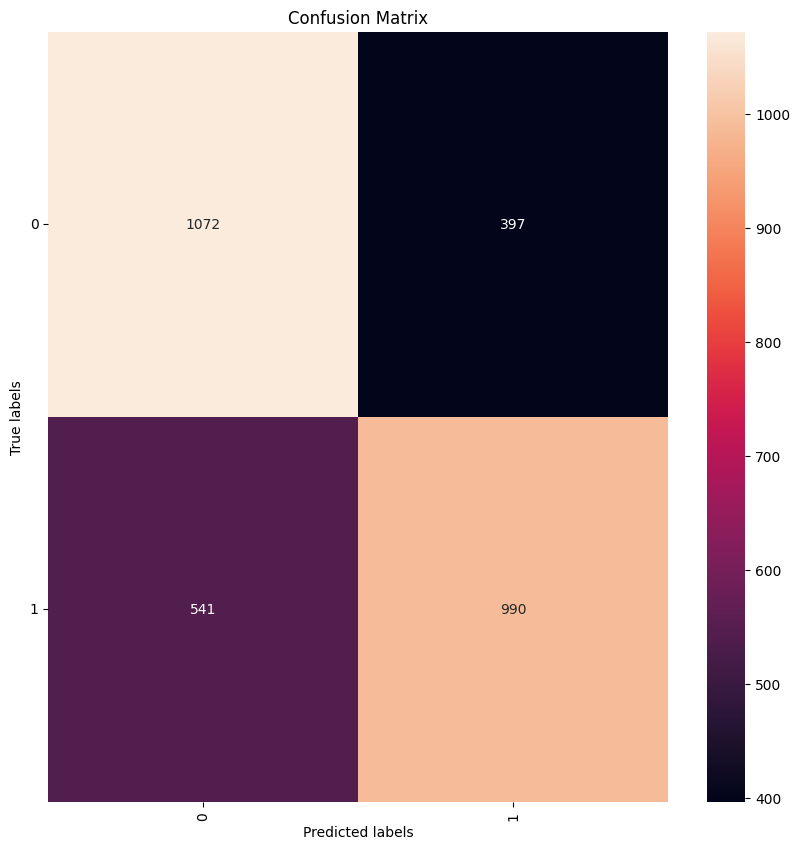

In [ ]:
trainer.run(train_loader, max_epochs=15) # RNN 1 A

  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 76.02 Сред. ошибка: 0.53320
Результат валидации - Эпоха: 1  Сред. точность: 75.60 Сред. ошибка: 0.53458


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 84.45 Сред. ошибка: 0.39904
Результат валидации - Эпоха: 2  Сред. точность: 84.10 Сред. ошибка: 0.40346


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 86.99 Сред. ошибка: 0.36070
Результат валидации - Эпоха: 3  Сред. точность: 85.60 Сред. ошибка: 0.38800


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 90.08 Сред. ошибка: 0.29515
Результат валидации - Эпоха: 4  Сред. точность: 87.33 Сред. ошибка: 0.34697


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 87.10 Сред. ошибка: 0.35629
Результат валидации - Эпоха: 5  Сред. точность: 86.50 Сред. ошибка: 0.37507


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 92.27 Сред. ошибка: 0.24430
Результат валидации - Эпоха: 6  Сред. точность: 90.23 Сред. ошибка: 0.29589


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 89.92 Сред. ошибка: 0.27757
Результат валидации - Эпоха: 7  Сред. точность: 86.00 Сред. ошибка: 0.36136


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 92.77 Сред. ошибка: 0.21472
Результат валидации - Эпоха: 8  Сред. точность: 88.40 Сред. ошибка: 0.31814


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 94.08 Сред. ошибка: 0.18909
Результат валидации - Эпоха: 9  Сред. точность: 90.90 Сред. ошибка: 0.27398


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 94.89 Сред. ошибка: 0.17071
Результат валидации - Эпоха: 10  Сред. точность: 91.03 Сред. ошибка: 0.28515


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 91.70 Сред. ошибка: 0.25086
Результат валидации - Эпоха: 11  Сред. точность: 90.43 Сред. ошибка: 0.28312


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 94.49 Сред. ошибка: 0.18652
Результат валидации - Эпоха: 12  Сред. точность: 90.83 Сред. ошибка: 0.30166


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 93.79 Сред. ошибка: 0.21233
Результат валидации - Эпоха: 13  Сред. точность: 92.40 Сред. ошибка: 0.26308


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 94.92 Сред. ошибка: 0.17842
Результат валидации - Эпоха: 14  Сред. точность: 92.53 Сред. ошибка: 0.26385


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 93.81 Сред. ошибка: 0.18884
Результат валидации - Эпоха: 15  Сред. точность: 90.00 Сред. ошибка: 0.28959


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 96.11 Сред. ошибка: 0.13409
Результат валидации - Эпоха: 16  Сред. точность: 92.60 Сред. ошибка: 0.24110


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 95.62 Сред. ошибка: 0.14886
Результат валидации - Эпоха: 17  Сред. точность: 91.33 Сред. ошибка: 0.27456


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 95.74 Сред. ошибка: 0.13971
Результат валидации - Эпоха: 18  Сред. точность: 91.77 Сред. ошибка: 0.25309


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 93.54 Сред. ошибка: 0.19577
Результат валидации - Эпоха: 19  Сред. точность: 89.47 Сред. ошибка: 0.31220


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 96.46 Сред. ошибка: 0.12315
Результат валидации - Эпоха: 20  Сред. точность: 91.77 Сред. ошибка: 0.27515


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 96.64 Сред. ошибка: 0.11659
Результат валидации - Эпоха: 21  Сред. точность: 91.90 Сред. ошибка: 0.26867


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 97.24 Сред. ошибка: 0.10082
Результат валидации - Эпоха: 22  Сред. точность: 91.77 Сред. ошибка: 0.27989


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 95.83 Сред. ошибка: 0.14312
Результат валидации - Эпоха: 23  Сред. точность: 90.50 Сред. ошибка: 0.29859


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 94.98 Сред. ошибка: 0.16809
Результат валидации - Эпоха: 24  Сред. точность: 90.63 Сред. ошибка: 0.30734


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 92.61 Сред. ошибка: 0.20954
Результат валидации - Эпоха: 25  Сред. точность: 86.07 Сред. ошибка: 0.36845


2025-04-13 22:31:08,980 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 13300
	epoch: 25
	epoch_length: 532
	max_epochs: 25
	output: 0.07008244097232819
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

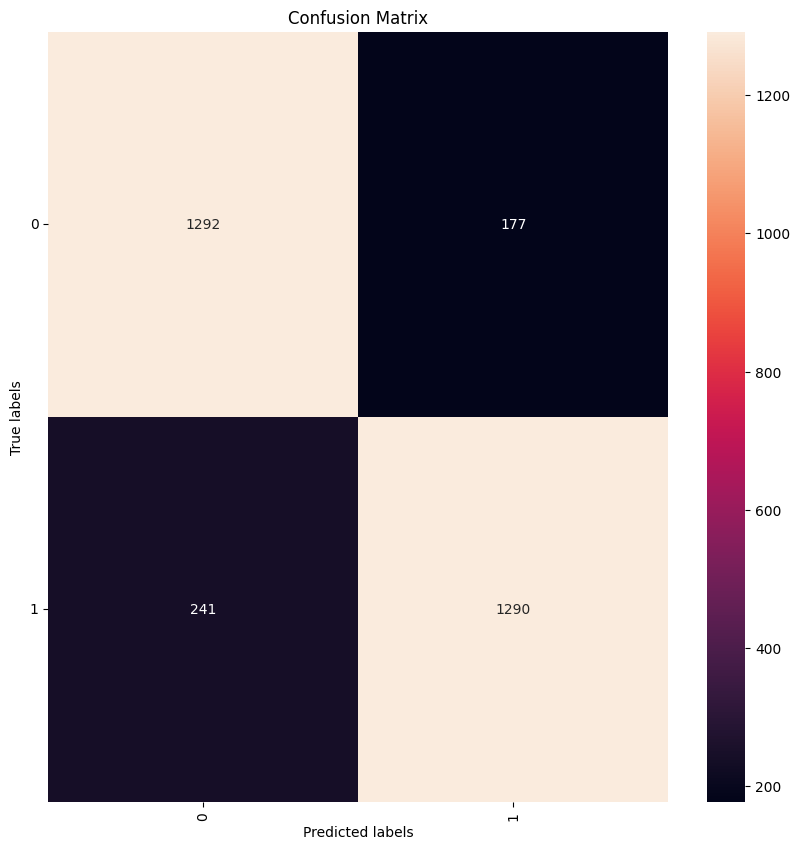

In [ ]:
trainer.run(train_loader, max_epochs=25) # RNN 1 B

  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 68.59 Сред. ошибка: 0.57779
Результат валидации - Эпоха: 1  Сред. точность: 68.43 Сред. ошибка: 0.58293


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 78.22 Сред. ошибка: 0.46341
Результат валидации - Эпоха: 2  Сред. точность: 74.20 Сред. ошибка: 0.50501


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 66.78 Сред. ошибка: 0.58481
Результат валидации - Эпоха: 3  Сред. точность: 63.63 Сред. ошибка: 0.60953


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 85.55 Сред. ошибка: 0.36726
Результат валидации - Эпоха: 4  Сред. точность: 82.60 Сред. ошибка: 0.43515


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 90.63 Сред. ошибка: 0.26983
Результат валидации - Эпоха: 5  Сред. точность: 87.87 Сред. ошибка: 0.32784


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 89.22 Сред. ошибка: 0.29393
Результат валидации - Эпоха: 6  Сред. точность: 87.90 Сред. ошибка: 0.33042


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 75.98 Сред. ошибка: 0.49946
Результат валидации - Эпоха: 7  Сред. точность: 67.60 Сред. ошибка: 0.61038


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 82.35 Сред. ошибка: 0.40262
Результат валидации - Эпоха: 8  Сред. точность: 72.37 Сред. ошибка: 0.55077


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 91.29 Сред. ошибка: 0.24561
Результат валидации - Эпоха: 9  Сред. точность: 87.67 Сред. ошибка: 0.33959


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 86.91 Сред. ошибка: 0.33706
Результат валидации - Эпоха: 10  Сред. точность: 82.87 Сред. ошибка: 0.46702


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 73.75 Сред. ошибка: 0.53119
Результат валидации - Эпоха: 11  Сред. точность: 64.47 Сред. ошибка: 0.63348


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 83.18 Сред. ошибка: 0.38158
Результат валидации - Эпоха: 12  Сред. точность: 72.83 Сред. ошибка: 0.56070


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 93.07 Сред. ошибка: 0.19676
Результат валидации - Эпоха: 13  Сред. точность: 88.30 Сред. ошибка: 0.32041


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 77.26 Сред. ошибка: 0.49519
Результат валидации - Эпоха: 14  Сред. точность: 69.10 Сред. ошибка: 0.59588


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 84.02 Сред. ошибка: 0.36156
Результат валидации - Эпоха: 15  Сред. точность: 74.03 Сред. ошибка: 0.52930


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 91.11 Сред. ошибка: 0.23533
Результат валидации - Эпоха: 16  Сред. точность: 83.40 Сред. ошибка: 0.38586


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 84.92 Сред. ошибка: 0.38605
Результат валидации - Эпоха: 17  Сред. точность: 84.20 Сред. ошибка: 0.44914


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 91.78 Сред. ошибка: 0.21630
Результат валидации - Эпоха: 18  Сред. точность: 84.43 Сред. ошибка: 0.38381


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 94.80 Сред. ошибка: 0.15562
Результат валидации - Эпоха: 19  Сред. точность: 90.67 Сред. ошибка: 0.26259


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 94.75 Сред. ошибка: 0.15065
Результат валидации - Эпоха: 20  Сред. точность: 88.47 Сред. ошибка: 0.32675


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 93.92 Сред. ошибка: 0.16531
Результат валидации - Эпоха: 21  Сред. точность: 85.17 Сред. ошибка: 0.36971


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 96.45 Сред. ошибка: 0.11049
Результат валидации - Эпоха: 22  Сред. точность: 90.87 Сред. ошибка: 0.26972


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 96.78 Сред. ошибка: 0.09869
Результат валидации - Эпоха: 23  Сред. точность: 90.77 Сред. ошибка: 0.26811


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 95.15 Сред. ошибка: 0.13993
Результат валидации - Эпоха: 24  Сред. точность: 89.07 Сред. ошибка: 0.31348


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 95.79 Сред. ошибка: 0.12321
Результат валидации - Эпоха: 25  Сред. точность: 90.73 Сред. ошибка: 0.28256


State:
	iteration: 13300
	epoch: 25
	epoch_length: 532
	max_epochs: 25
	output: 0.6151717901229858
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

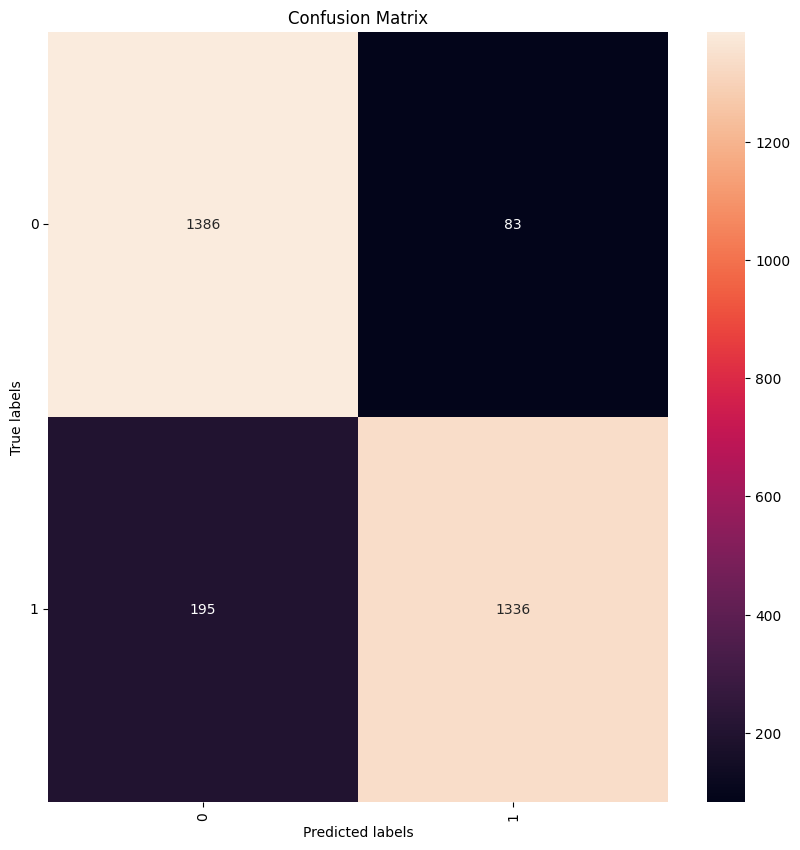

In [ ]:
trainer.run(train_loader, max_epochs=25) # RNN 1 C

  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 90.22 Сред. ошибка: 0.24883
Результат валидации - Эпоха: 1  Сред. точность: 89.20 Сред. ошибка: 0.26910


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 81.55 Сред. ошибка: 0.39727
Результат валидации - Эпоха: 2  Сред. точность: 80.40 Сред. ошибка: 0.42465


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 85.68 Сред. ошибка: 0.34462
Результат валидации - Эпоха: 3  Сред. точность: 83.57 Сред. ошибка: 0.37946


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 92.46 Сред. ошибка: 0.20248
Результат валидации - Эпоха: 4  Сред. точность: 90.27 Сред. ошибка: 0.25775


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 93.69 Сред. ошибка: 0.16661
Результат валидации - Эпоха: 5  Сред. точность: 91.50 Сред. ошибка: 0.22442


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.71 Сред. ошибка: 0.09939
Результат валидации - Эпоха: 6  Сред. точность: 93.70 Сред. ошибка: 0.16206


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 97.41 Сред. ошибка: 0.08018
Результат валидации - Эпоха: 7  Сред. точность: 94.40 Сред. ошибка: 0.15535


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 97.54 Сред. ошибка: 0.07307
Результат валидации - Эпоха: 8  Сред. точность: 95.47 Сред. ошибка: 0.13966


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 96.44 Сред. ошибка: 0.10835
Результат валидации - Эпоха: 9  Сред. точность: 93.13 Сред. ошибка: 0.17913


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 95.08 Сред. ошибка: 0.12866
Результат валидации - Эпоха: 10  Сред. точность: 92.83 Сред. ошибка: 0.19849


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 92.89 Сред. ошибка: 0.18628
Результат валидации - Эпоха: 11  Сред. точность: 88.70 Сред. ошибка: 0.27978


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 96.21 Сред. ошибка: 0.10904
Результат валидации - Эпоха: 12  Сред. точность: 93.87 Сред. ошибка: 0.17382


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 97.00 Сред. ошибка: 0.08842
Результат валидации - Эпоха: 13  Сред. точность: 94.13 Сред. ошибка: 0.15986


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 97.65 Сред. ошибка: 0.06482
Результат валидации - Эпоха: 14  Сред. точность: 95.93 Сред. ошибка: 0.13445


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 95.98 Сред. ошибка: 0.11059
Результат валидации - Эпоха: 15  Сред. точность: 94.13 Сред. ошибка: 0.18473


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 97.25 Сред. ошибка: 0.07658
Результат валидации - Эпоха: 16  Сред. точность: 93.73 Сред. ошибка: 0.19034


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 98.57 Сред. ошибка: 0.04302
Результат валидации - Эпоха: 17  Сред. точность: 95.80 Сред. ошибка: 0.14134


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 95.92 Сред. ошибка: 0.10982
Результат валидации - Эпоха: 18  Сред. точность: 93.13 Сред. ошибка: 0.19313


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 95.12 Сред. ошибка: 0.12993
Результат валидации - Эпоха: 19  Сред. точность: 92.40 Сред. ошибка: 0.22140


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 98.13 Сред. ошибка: 0.05259
Результат валидации - Эпоха: 20  Сред. точность: 95.00 Сред. ошибка: 0.14222


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 98.84 Сред. ошибка: 0.03485
Результат валидации - Эпоха: 21  Сред. точность: 94.67 Сред. ошибка: 0.17430


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 98.88 Сред. ошибка: 0.03182
Результат валидации - Эпоха: 22  Сред. точность: 94.70 Сред. ошибка: 0.17540


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 98.26 Сред. ошибка: 0.05262
Результат валидации - Эпоха: 23  Сред. точность: 94.63 Сред. ошибка: 0.15783


  0%|          | 1/532 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 98.92 Сред. ошибка: 0.03137


2025-04-13 23:31:08,522 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации - Эпоха: 24  Сред. точность: 94.77 Сред. ошибка: 0.17474


2025-04-13 23:31:10,480 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 12768
	epoch: 24
	epoch_length: 532
	max_epochs: 25
	output: 0.5681074857711792
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

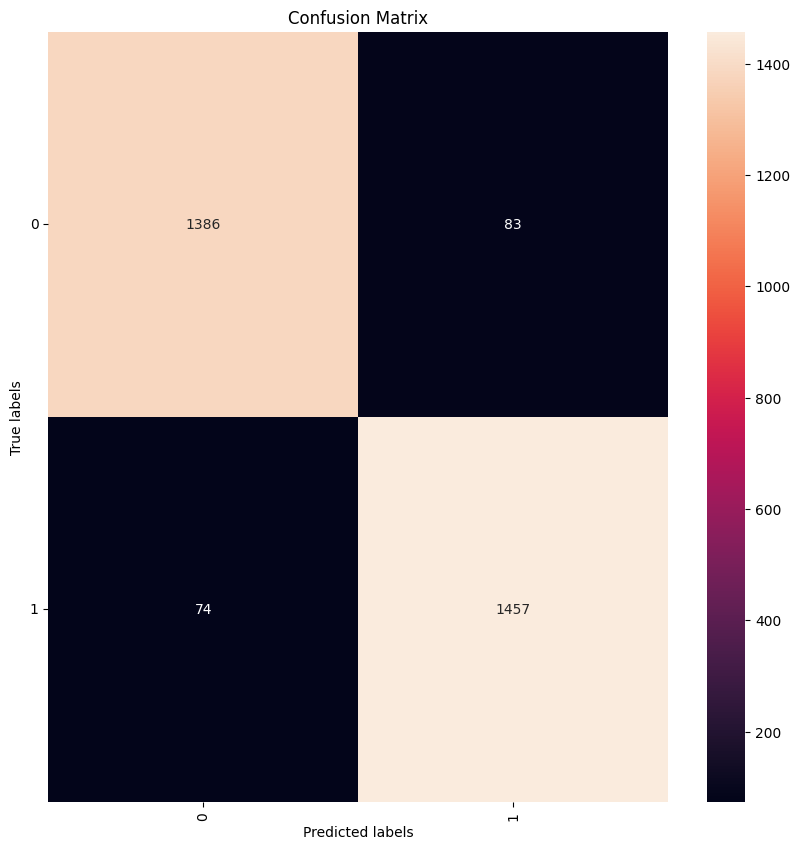

In [ ]:
trainer.run(train_loader, max_epochs=25) # RNN 2 A

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 83.81 Сред. ошибка: 0.37359
Результат валидации - Эпоха: 1  Сред. точность: 82.83 Сред. ошибка: 0.38544


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 89.95 Сред. ошибка: 0.25316
Результат валидации - Эпоха: 2  Сред. точность: 88.43 Сред. ошибка: 0.27982


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 92.84 Сред. ошибка: 0.20051
Результат валидации - Эпоха: 3  Сред. точность: 91.00 Сред. ошибка: 0.23773


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 94.45 Сред. ошибка: 0.15329
Результат валидации - Эпоха: 4  Сред. точность: 92.53 Сред. ошибка: 0.19964


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 95.71 Сред. ошибка: 0.12487
Результат валидации - Эпоха: 5  Сред. точность: 94.77 Сред. ошибка: 0.15502


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 97.10 Сред. ошибка: 0.08089
Результат валидации - Эпоха: 6  Сред. точность: 94.80 Сред. ошибка: 0.15181


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 97.02 Сред. ошибка: 0.07918
Результат валидации - Эпоха: 7  Сред. точность: 94.77 Сред. ошибка: 0.15595


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 95.68 Сред. ошибка: 0.11407
Результат валидации - Эпоха: 8  Сред. точность: 93.27 Сред. ошибка: 0.18130


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 96.54 Сред. ошибка: 0.09257
Результат валидации - Эпоха: 9  Сред. точность: 93.90 Сред. ошибка: 0.16761


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 98.04 Сред. ошибка: 0.05806
Результат валидации - Эпоха: 10  Сред. точность: 94.50 Сред. ошибка: 0.15683


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 92.19 Сред. ошибка: 0.20400
Результат валидации - Эпоха: 11  Сред. точность: 90.33 Сред. ошибка: 0.23956


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 98.04 Сред. ошибка: 0.05810
Результат валидации - Эпоха: 12  Сред. точность: 95.50 Сред. ошибка: 0.14268


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 98.64 Сред. ошибка: 0.04110
Результат валидации - Эпоха: 13  Сред. точность: 95.20 Сред. ошибка: 0.14444


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.03 Сред. ошибка: 0.03033
Результат валидации - Эпоха: 14  Сред. точность: 96.27 Сред. ошибка: 0.12478


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 97.52 Сред. ошибка: 0.07064
Результат валидации - Эпоха: 15  Сред. точность: 94.50 Сред. ошибка: 0.16302


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 98.75 Сред. ошибка: 0.03918
Результат валидации - Эпоха: 16  Сред. точность: 94.07 Сред. ошибка: 0.19172


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.05 Сред. ошибка: 0.03010
Результат валидации - Эпоха: 17  Сред. точность: 95.57 Сред. ошибка: 0.15761


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 97.05 Сред. ошибка: 0.08602
Результат валидации - Эпоха: 18  Сред. точность: 93.63 Сред. ошибка: 0.18177


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 98.02 Сред. ошибка: 0.05459
Результат валидации - Эпоха: 19  Сред. точность: 94.73 Сред. ошибка: 0.15438


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 98.76 Сред. ошибка: 0.03782
Результат валидации - Эпоха: 20  Сред. точность: 95.43 Сред. ошибка: 0.13769


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.26 Сред. ошибка: 0.02113
Результат валидации - Эпоха: 21  Сред. точность: 95.87 Сред. ошибка: 0.15359


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.44 Сред. ошибка: 0.01681
Результат валидации - Эпоха: 22  Сред. точность: 95.97 Сред. ошибка: 0.15798


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.48 Сред. ошибка: 0.01761
Результат валидации - Эпоха: 23  Сред. точность: 95.87 Сред. ошибка: 0.17961


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.52 Сред. ошибка: 0.01515
Результат валидации - Эпоха: 24  Сред. точность: 96.47 Сред. ошибка: 0.14173


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 98.86 Сред. ошибка: 0.03054
Результат валидации - Эпоха: 25  Сред. точность: 95.27 Сред. ошибка: 0.15887


State:
	iteration: 6650
	epoch: 25
	epoch_length: 266
	max_epochs: 25
	output: 0.003583773272112012
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

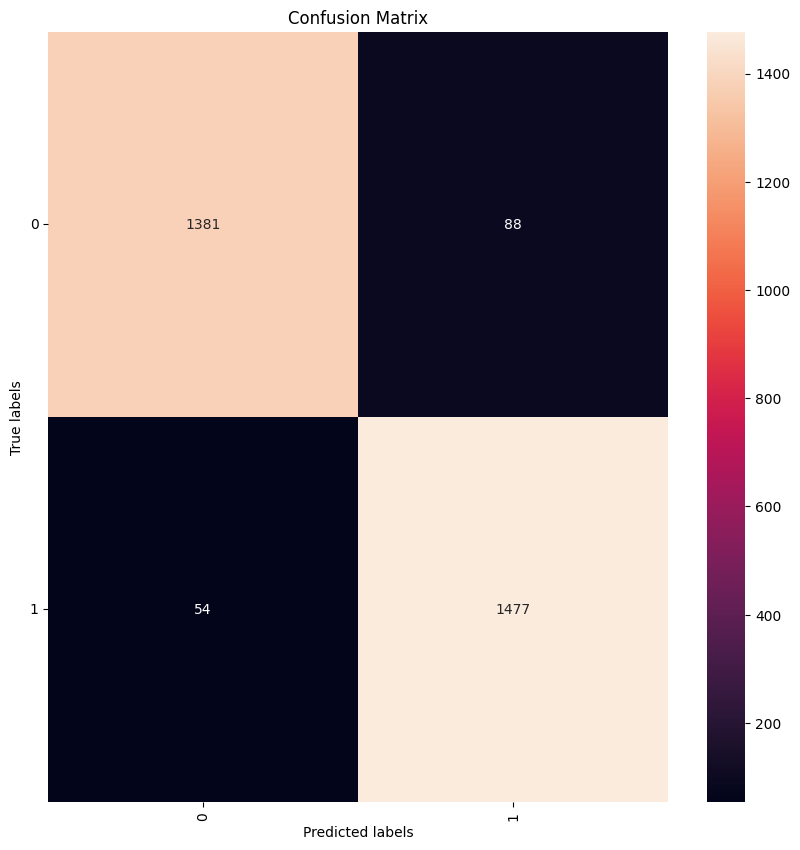

In [ ]:
trainer.run(train_loader, max_epochs=25) # RNN 2 B

  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 85.40 Сред. ошибка: 0.34787
Результат валидации - Эпоха: 1  Сред. точность: 84.00 Сред. ошибка: 0.37057


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 82.24 Сред. ошибка: 0.40952
Результат валидации - Эпоха: 2  Сред. точность: 81.27 Сред. ошибка: 0.42242


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 90.09 Сред. ошибка: 0.24944
Результат валидации - Эпоха: 3  Сред. точность: 88.00 Сред. ошибка: 0.30179


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 92.59 Сред. ошибка: 0.20184
Результат валидации - Эпоха: 4  Сред. точность: 90.50 Сред. ошибка: 0.25071


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 95.44 Сред. ошибка: 0.12525
Результат валидации - Эпоха: 5  Сред. точность: 92.93 Сред. ошибка: 0.17941


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.31 Сред. ошибка: 0.10302
Результат валидации - Эпоха: 6  Сред. точность: 93.87 Сред. ошибка: 0.16676


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 91.89 Сред. ошибка: 0.21468
Результат валидации - Эпоха: 7  Сред. точность: 89.83 Сред. ошибка: 0.26479


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 92.72 Сред. ошибка: 0.19560
Результат валидации - Эпоха: 8  Сред. точность: 90.07 Сред. ошибка: 0.27922


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 96.56 Сред. ошибка: 0.09738
Результат валидации - Эпоха: 9  Сред. точность: 94.43 Сред. ошибка: 0.15932


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 93.27 Сред. ошибка: 0.18457
Результат валидации - Эпоха: 10  Сред. точность: 91.73 Сред. ошибка: 0.23035


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 94.00 Сред. ошибка: 0.16372
Результат валидации - Эпоха: 11  Сред. точность: 91.63 Сред. ошибка: 0.24752


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 96.92 Сред. ошибка: 0.09340
Результат валидации - Эпоха: 12  Сред. точность: 93.60 Сред. ошибка: 0.18705


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 97.54 Сред. ошибка: 0.08183
Результат валидации - Эпоха: 13  Сред. точность: 94.10 Сред. ошибка: 0.17715


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 91.93 Сред. ошибка: 0.19470
Результат валидации - Эпоха: 14  Сред. точность: 87.80 Сред. ошибка: 0.29285


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 96.81 Сред. ошибка: 0.09848
Результат валидации - Эпоха: 15  Сред. точность: 93.27 Сред. ошибка: 0.18524


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 95.01 Сред. ошибка: 0.13518
Результат валидации - Эпоха: 16  Сред. точность: 91.93 Сред. ошибка: 0.22181


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 92.28 Сред. ошибка: 0.17196
Результат валидации - Эпоха: 17  Сред. точность: 90.23 Сред. ошибка: 0.22607


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 97.28 Сред. ошибка: 0.07520
Результат валидации - Эпоха: 18  Сред. точность: 94.07 Сред. ошибка: 0.16511


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 98.49 Сред. ошибка: 0.04499
Результат валидации - Эпоха: 19  Сред. точность: 95.60 Сред. ошибка: 0.14263


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 98.90 Сред. ошибка: 0.03525
Результат валидации - Эпоха: 20  Сред. точность: 95.43 Сред. ошибка: 0.14756


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.35 Сред. ошибка: 0.02386
Результат валидации - Эпоха: 21  Сред. точность: 96.00 Сред. ошибка: 0.14126


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 98.92 Сред. ошибка: 0.03412
Результат валидации - Эпоха: 22  Сред. точность: 95.93 Сред. ошибка: 0.11976


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.12 Сред. ошибка: 0.02718
Результат валидации - Эпоха: 23  Сред. точность: 95.27 Сред. ошибка: 0.14508


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 98.99 Сред. ошибка: 0.03310
Результат валидации - Эпоха: 24  Сред. точность: 95.60 Сред. ошибка: 0.14016


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.31 Сред. ошибка: 0.02232
Результат валидации - Эпоха: 25  Сред. точность: 95.63 Сред. ошибка: 0.13909


State:
	iteration: 3325
	epoch: 25
	epoch_length: 133
	max_epochs: 25
	output: 0.019077572971582413
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

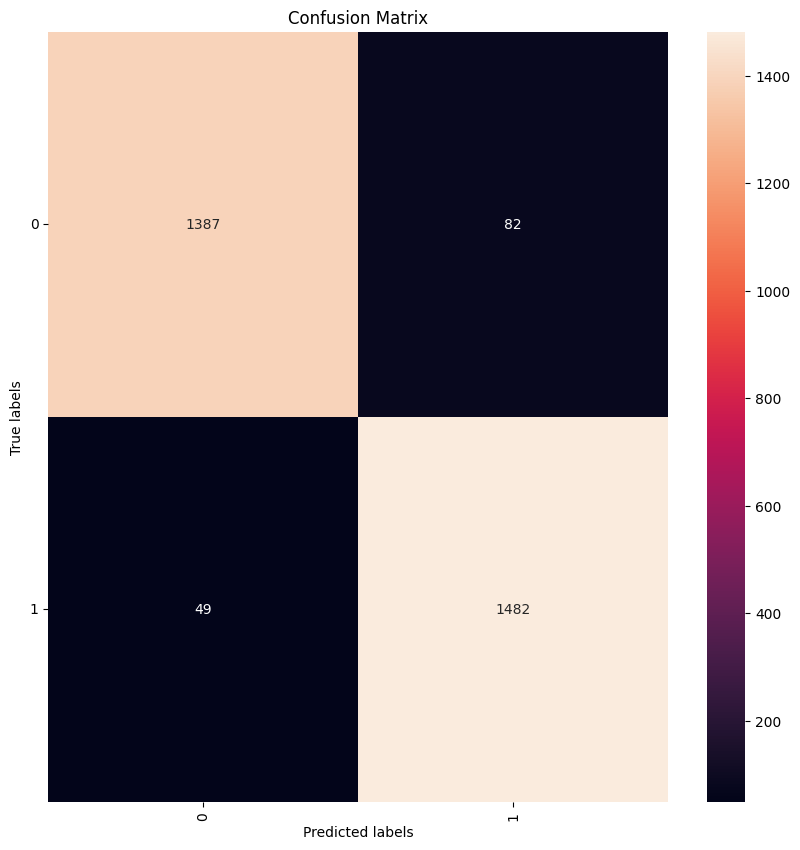

In [ ]:
trainer.run(train_loader, max_epochs=25) # RNN 2 C

  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 79.71 Сред. ошибка: 0.44785
Результат валидации - Эпоха: 1  Сред. точность: 79.03 Сред. ошибка: 0.45613


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 84.54 Сред. ошибка: 0.37766
Результат валидации - Эпоха: 2  Сред. точность: 83.07 Сред. ошибка: 0.39473


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 93.06 Сред. ошибка: 0.20903
Результат валидации - Эпоха: 3  Сред. точность: 91.50 Сред. ошибка: 0.23415


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 95.58 Сред. ошибка: 0.15051
Результат валидации - Эпоха: 4  Сред. точность: 93.73 Сред. ошибка: 0.19282


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 95.51 Сред. ошибка: 0.14388
Результат валидации - Эпоха: 5  Сред. точность: 93.37 Сред. ошибка: 0.20540


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.79 Сред. ошибка: 0.10943
Результат валидации - Эпоха: 6  Сред. точность: 94.13 Сред. ошибка: 0.18232


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 97.35 Сред. ошибка: 0.09429
Результат валидации - Эпоха: 7  Сред. точность: 94.60 Сред. ошибка: 0.17304


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 97.98 Сред. ошибка: 0.07773
Результат валидации - Эпоха: 8  Сред. точность: 95.83 Сред. ошибка: 0.15439


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 98.46 Сред. ошибка: 0.06438
Результат валидации - Эпоха: 9  Сред. точность: 95.50 Сред. ошибка: 0.14776


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 98.49 Сред. ошибка: 0.06118
Результат валидации - Эпоха: 10  Сред. точность: 95.13 Сред. ошибка: 0.14985


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 98.98 Сред. ошибка: 0.04422
Результат валидации - Эпоха: 11  Сред. точность: 96.37 Сред. ошибка: 0.12502


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.20 Сред. ошибка: 0.03588
Результат валидации - Эпоха: 12  Сред. точность: 96.73 Сред. ошибка: 0.12240


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.18 Сред. ошибка: 0.03639
Результат валидации - Эпоха: 13  Сред. точность: 96.37 Сред. ошибка: 0.13661


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 62.32 Сред. ошибка: 1.64581
Результат валидации - Эпоха: 14  Сред. точность: 62.00 Сред. ошибка: 1.68512


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 94.59 Сред. ошибка: 0.14903
Результат валидации - Эпоха: 15  Сред. точность: 92.43 Сред. ошибка: 0.21352


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 98.12 Сред. ошибка: 0.07066
Результат валидации - Эпоха: 16  Сред. точность: 95.50 Сред. ошибка: 0.15287


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 93.65 Сред. ошибка: 0.17327
Результат валидации - Эпоха: 17  Сред. точность: 90.43 Сред. ошибка: 0.25842


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 98.89 Сред. ошибка: 0.04538
Результат валидации - Эпоха: 18  Сред. точность: 95.93 Сред. ошибка: 0.14729


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.11 Сред. ошибка: 0.03910
Результат валидации - Эпоха: 19  Сред. точность: 96.33 Сред. ошибка: 0.14522


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 98.52 Сред. ошибка: 0.06676
Результат валидации - Эпоха: 20  Сред. точность: 95.53 Сред. ошибка: 0.19582


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 98.05 Сред. ошибка: 0.08127
Результат валидации - Эпоха: 21  Сред. точность: 94.83 Сред. ошибка: 0.20584


  1%|          | 1/133 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 91.75 Сред. ошибка: 0.25758


2025-04-14 00:23:14,469 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации - Эпоха: 22  Сред. точность: 89.47 Сред. ошибка: 0.39160


2025-04-14 00:23:14,688 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 2926
	epoch: 22
	epoch_length: 133
	max_epochs: 25
	output: 0.12380088865756989
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

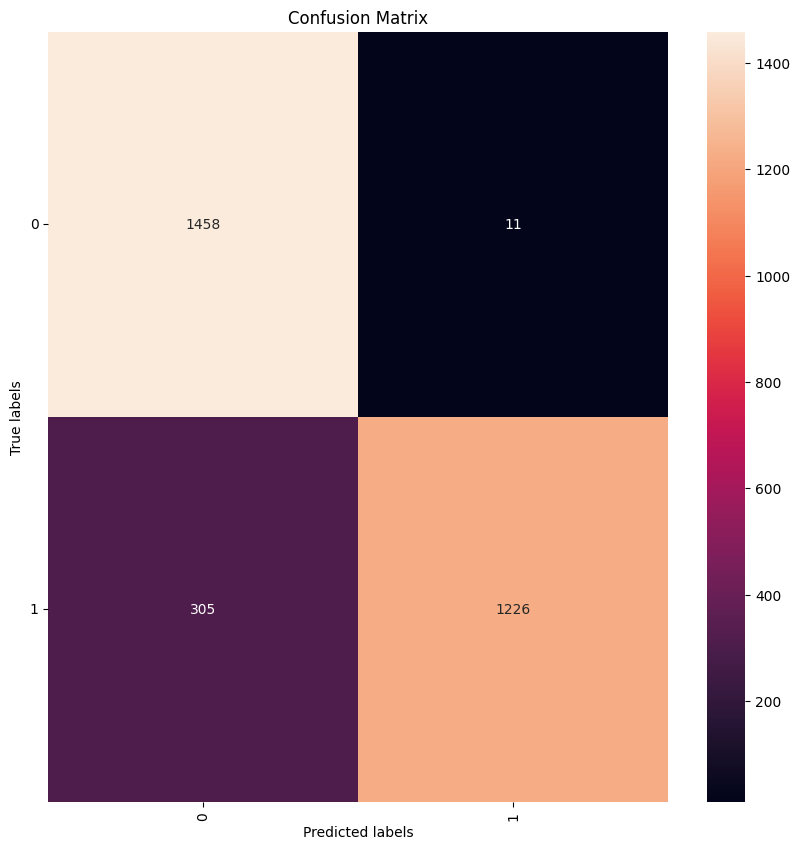

In [ ]:
trainer.run(train_loader, max_epochs=25) # LSTM 1 A

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 88.72 Сред. ошибка: 0.32134
Результат валидации - Эпоха: 1  Сред. точность: 87.33 Сред. ошибка: 0.34667


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 50.29 Сред. ошибка: 0.69112
Результат валидации - Эпоха: 2  Сред. точность: 48.27 Сред. ошибка: 0.69387


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 87.73 Сред. ошибка: 0.38069
Результат валидации - Эпоха: 3  Сред. точность: 86.50 Сред. ошибка: 0.39219


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 97.32 Сред. ошибка: 0.10098
Результат валидации - Эпоха: 4  Сред. точность: 95.57 Сред. ошибка: 0.14796


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 98.55 Сред. ошибка: 0.05576
Результат валидации - Эпоха: 5  Сред. точность: 96.77 Сред. ошибка: 0.11168


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 98.76 Сред. ошибка: 0.04544
Результат валидации - Эпоха: 6  Сред. точность: 96.73 Сред. ошибка: 0.11681


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 99.11 Сред. ошибка: 0.03660
Результат валидации - Эпоха: 7  Сред. точность: 97.03 Сред. ошибка: 0.12128


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 99.47 Сред. ошибка: 0.02300
Результат валидации - Эпоха: 8  Сред. точность: 97.47 Сред. ошибка: 0.10327


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.25 Сред. ошибка: 0.02517
Результат валидации - Эпоха: 9  Сред. точность: 96.67 Сред. ошибка: 0.09202


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.65 Сред. ошибка: 0.01567
Результат валидации - Эпоха: 10  Сред. точность: 97.47 Сред. ошибка: 0.10137


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.79 Сред. ошибка: 0.01213
Результат валидации - Эпоха: 11  Сред. точность: 97.67 Сред. ошибка: 0.11260


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.87 Сред. ошибка: 0.00832
Результат валидации - Эпоха: 12  Сред. точность: 97.80 Сред. ошибка: 0.10925


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.91 Сред. ошибка: 0.00662
Результат валидации - Эпоха: 13  Сред. точность: 97.80 Сред. ошибка: 0.11982


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.76 Сред. ошибка: 0.00921
Результат валидации - Эпоха: 14  Сред. точность: 97.53 Сред. ошибка: 0.10966


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.85 Сред. ошибка: 0.00671
Результат валидации - Эпоха: 15  Сред. точность: 97.77 Сред. ошибка: 0.12240


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.93 Сред. ошибка: 0.00428
Результат валидации - Эпоха: 16  Сред. точность: 98.03 Сред. ошибка: 0.12976


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.92 Сред. ошибка: 0.00372
Результат валидации - Эпоха: 17  Сред. точность: 98.10 Сред. ошибка: 0.11542


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.95 Сред. ошибка: 0.00320
Результат валидации - Эпоха: 18  Сред. точность: 98.33 Сред. ошибка: 0.11784


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.91 Сред. ошибка: 0.00326
Результат валидации - Эпоха: 19  Сред. точность: 98.20 Сред. ошибка: 0.10699


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.96 Сред. ошибка: 0.00146
Результат валидации - Эпоха: 20  Сред. точность: 98.17 Сред. ошибка: 0.11861


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.96 Сред. ошибка: 0.00184
Результат валидации - Эпоха: 21  Сред. точность: 98.03 Сред. ошибка: 0.13290


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.95 Сред. ошибка: 0.00175
Результат валидации - Эпоха: 22  Сред. точность: 98.07 Сред. ошибка: 0.13964


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.96 Сред. ошибка: 0.00108
Результат валидации - Эпоха: 23  Сред. точность: 98.17 Сред. ошибка: 0.13717


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.85 Сред. ошибка: 0.00521
Результат валидации - Эпоха: 24  Сред. точность: 98.07 Сред. ошибка: 0.14960


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.95 Сред. ошибка: 0.00233
Результат валидации - Эпоха: 25  Сред. точность: 97.77 Сред. ошибка: 0.14671


State:
	iteration: 6650
	epoch: 25
	epoch_length: 266
	max_epochs: 25
	output: 0.00033566594356670976
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

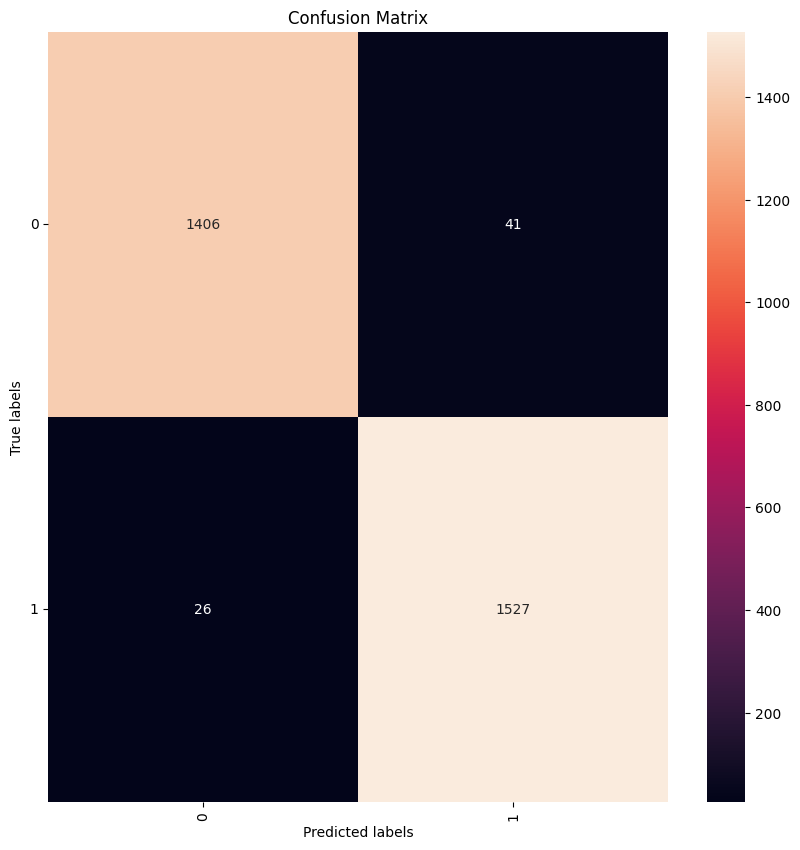

In [ ]:
trainer.run(train_loader, max_epochs=25) # LSTM 1 B

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 89.41 Сред. ошибка: 0.29877
Результат валидации - Эпоха: 1  Сред. точность: 87.53 Сред. ошибка: 0.32807


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 91.77 Сред. ошибка: 0.23779
Результат валидации - Эпоха: 2  Сред. точность: 89.37 Сред. ошибка: 0.28242


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 86.45 Сред. ошибка: 0.37454
Результат валидации - Эпоха: 3  Сред. точность: 85.20 Сред. ошибка: 0.42073


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 77.38 Сред. ошибка: 0.51955
Результат валидации - Эпоха: 4  Сред. точность: 76.20 Сред. ошибка: 0.52961


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 95.49 Сред. ошибка: 0.13673
Результат валидации - Эпоха: 5  Сред. точность: 92.73 Сред. ошибка: 0.21595


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 92.24 Сред. ошибка: 0.20629
Результат валидации - Эпоха: 6  Сред. точность: 89.50 Сред. ошибка: 0.26785


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 97.97 Сред. ошибка: 0.07031
Результат валидации - Эпоха: 7  Сред. точность: 95.63 Сред. ошибка: 0.14503


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 97.38 Сред. ошибка: 0.09515
Результат валидации - Эпоха: 8  Сред. точность: 94.80 Сред. ошибка: 0.20047


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 98.38 Сред. ошибка: 0.05696
Результат валидации - Эпоха: 9  Сред. точность: 96.30 Сред. ошибка: 0.15201


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 91.76 Сред. ошибка: 0.19697
Результат валидации - Эпоха: 10  Сред. точность: 88.80 Сред. ошибка: 0.27671


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 98.17 Сред. ошибка: 0.05861
Результат валидации - Эпоха: 11  Сред. точность: 95.43 Сред. ошибка: 0.15737


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.16 Сред. ошибка: 0.03374
Результат валидации - Эпоха: 12  Сред. точность: 96.30 Сред. ошибка: 0.15192


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.35 Сред. ошибка: 0.02865
Результат валидации - Эпоха: 13  Сред. точность: 96.43 Сред. ошибка: 0.15593


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.26 Сред. ошибка: 0.02707
Результат валидации - Эпоха: 14  Сред. точность: 96.10 Сред. ошибка: 0.14852


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.18 Сред. ошибка: 0.02987
Результат валидации - Эпоха: 15  Сред. точность: 96.63 Сред. ошибка: 0.12695


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.66 Сред. ошибка: 0.01464
Результат валидации - Эпоха: 16  Сред. точность: 97.07 Сред. ошибка: 0.12761


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 96.64 Сред. ошибка: 0.09854
Результат валидации - Эпоха: 17  Сред. точность: 93.23 Сред. ошибка: 0.20269


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 96.58 Сред. ошибка: 0.10897
Результат валидации - Эпоха: 18  Сред. точность: 93.63 Сред. ошибка: 0.25364


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.61 Сред. ошибка: 0.01398
Результат валидации - Эпоха: 19  Сред. точность: 96.77 Сред. ошибка: 0.15456


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.61 Сред. ошибка: 0.01443
Результат валидации - Эпоха: 20  Сред. точность: 96.73 Сред. ошибка: 0.14217


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.87 Сред. ошибка: 0.00677
Результат валидации - Эпоха: 21  Сред. точность: 97.23 Сред. ошибка: 0.13156


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.89 Сред. ошибка: 0.00489
Результат валидации - Эпоха: 22  Сред. точность: 97.07 Сред. ошибка: 0.15922


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.88 Сред. ошибка: 0.00566
Результат валидации - Эпоха: 23  Сред. точность: 97.10 Сред. ошибка: 0.16120


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.94 Сред. ошибка: 0.00401
Результат валидации - Эпоха: 24  Сред. точность: 97.10 Сред. ошибка: 0.16276


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.64 Сред. ошибка: 0.01316
Результат валидации - Эпоха: 25  Сред. точность: 96.57 Сред. ошибка: 0.14814


State:
	iteration: 6650
	epoch: 25
	epoch_length: 266
	max_epochs: 25
	output: 0.0030102638993412256
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

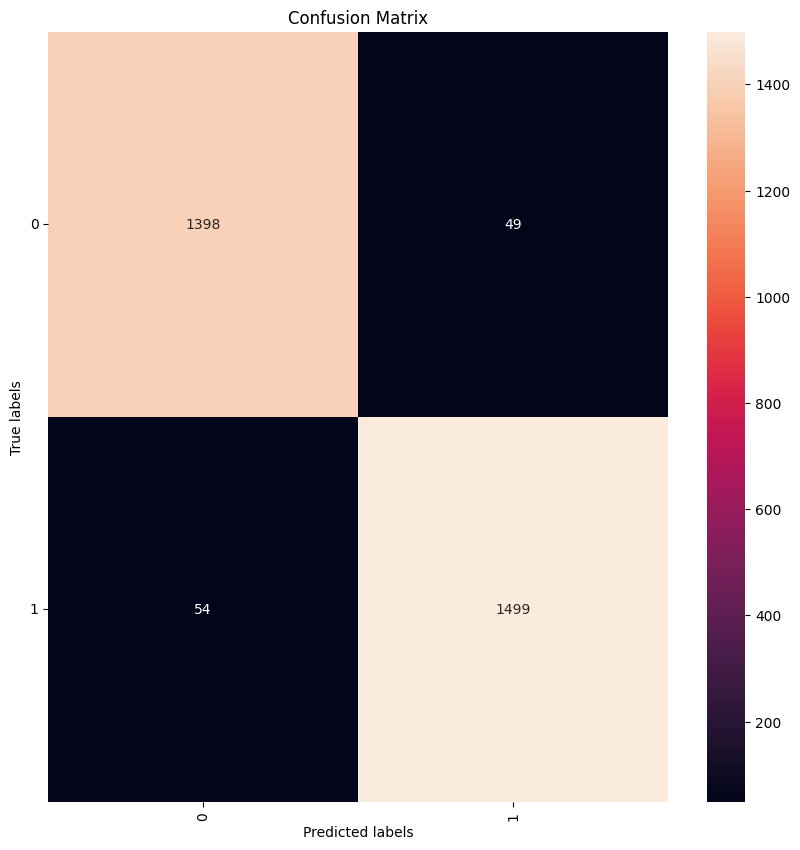

In [ ]:
trainer.run(train_loader, max_epochs=25) # LSTM 1 C

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 92.66 Сред. ошибка: 0.19624
Результат валидации - Эпоха: 1  Сред. точность: 91.70 Сред. ошибка: 0.23662


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 97.06 Сред. ошибка: 0.08946
Результат валидации - Эпоха: 2  Сред. точность: 95.63 Сред. ошибка: 0.13799


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 97.21 Сред. ошибка: 0.08224
Результат валидации - Эпоха: 3  Сред. точность: 95.03 Сред. ошибка: 0.14591


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 98.22 Сред. ошибка: 0.05247
Результат валидации - Эпоха: 4  Сред. точность: 95.93 Сред. ошибка: 0.11402


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 98.84 Сред. ошибка: 0.03666
Результат валидации - Эпоха: 5  Сред. точность: 95.87 Сред. ошибка: 0.12475


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 99.12 Сред. ошибка: 0.02661
Результат валидации - Эпоха: 6  Сред. точность: 96.77 Сред. ошибка: 0.10051


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 99.48 Сред. ошибка: 0.01738
Результат валидации - Эпоха: 7  Сред. точность: 97.57 Сред. ошибка: 0.12207


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 99.81 Сред. ошибка: 0.00732
Результат валидации - Эпоха: 8  Сред. точность: 97.47 Сред. ошибка: 0.10578


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.67 Сред. ошибка: 0.01215
Результат валидации - Эпоха: 9  Сред. точность: 97.33 Сред. ошибка: 0.10613


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.53 Сред. ошибка: 0.01491
Результат валидации - Эпоха: 10  Сред. точность: 96.80 Сред. ошибка: 0.12335


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.66 Сред. ошибка: 0.01168
Результат валидации - Эпоха: 11  Сред. точность: 97.33 Сред. ошибка: 0.11252


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.84 Сред. ошибка: 0.00547
Результат валидации - Эпоха: 12  Сред. точность: 97.57 Сред. ошибка: 0.10801


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.95 Сред. ошибка: 0.00219
Результат валидации - Эпоха: 13  Сред. точность: 97.77 Сред. ошибка: 0.11996


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.95 Сред. ошибка: 0.00140
Результат валидации - Эпоха: 14  Сред. точность: 97.53 Сред. ошибка: 0.13753


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.98 Сред. ошибка: 0.00113
Результат валидации - Эпоха: 15  Сред. точность: 97.80 Сред. ошибка: 0.13645


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.95 Сред. ошибка: 0.00160
Результат валидации - Эпоха: 16  Сред. точность: 97.13 Сред. ошибка: 0.17047


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 100.00 Сред. ошибка: 0.00012
Результат валидации - Эпоха: 17  Сред. точность: 97.73 Сред. ошибка: 0.15197


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.73 Сред. ошибка: 0.00889
Результат валидации - Эпоха: 18  Сред. точность: 96.93 Сред. ошибка: 0.15356


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.86 Сред. ошибка: 0.00552
Результат валидации - Эпоха: 19  Сред. точность: 97.47 Сред. ошибка: 0.12012


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.96 Сред. ошибка: 0.00095
Результат валидации - Эпоха: 20  Сред. точность: 97.83 Сред. ошибка: 0.12548


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.94 Сред. ошибка: 0.00220
Результат валидации - Эпоха: 21  Сред. точность: 97.73 Сред. ошибка: 0.10020


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.91 Сред. ошибка: 0.00267
Результат валидации - Эпоха: 22  Сред. точность: 97.50 Сред. ошибка: 0.13555


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.99 Сред. ошибка: 0.00017
Результат валидации - Эпоха: 23  Сред. точность: 97.93 Сред. ошибка: 0.14842


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 100.00 Сред. ошибка: 0.00004
Результат валидации - Эпоха: 24  Сред. точность: 98.03 Сред. ошибка: 0.15469


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.99 Сред. ошибка: 0.00024
Результат валидации - Эпоха: 25  Сред. точность: 97.50 Сред. ошибка: 0.18153


State:
	iteration: 6650
	epoch: 25
	epoch_length: 266
	max_epochs: 25
	output: 9.59628550845082e-07
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

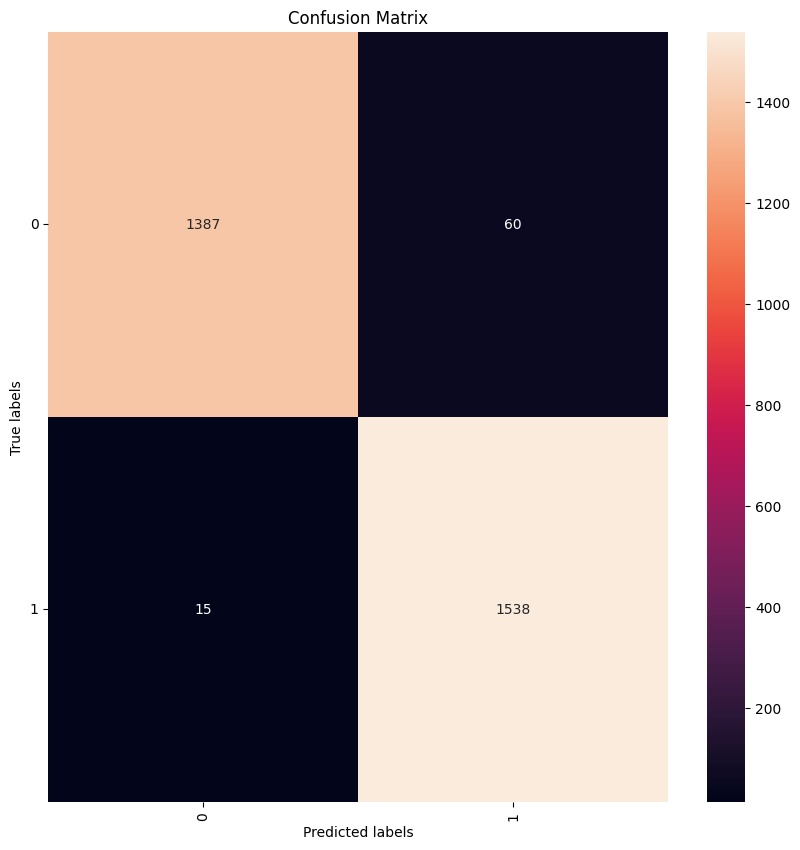

In [ ]:
trainer.run(train_loader, max_epochs=25) # LSTM 2 A

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 89.73 Сред. ошибка: 0.27149
Результат валидации - Эпоха: 1  Сред. точность: 88.67 Сред. ошибка: 0.29770


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 95.25 Сред. ошибка: 0.13053
Результат валидации - Эпоха: 2  Сред. точность: 93.97 Сред. ошибка: 0.16690


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 97.84 Сред. ошибка: 0.06486
Результат валидации - Эпоха: 3  Сред. точность: 95.43 Сред. ошибка: 0.12704


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 98.08 Сред. ошибка: 0.06099
Результат валидации - Эпоха: 4  Сред. точность: 95.87 Сред. ошибка: 0.12920


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 97.38 Сред. ошибка: 0.07842
Результат валидации - Эпоха: 5  Сред. точность: 95.07 Сред. ошибка: 0.15121


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 98.81 Сред. ошибка: 0.03735
Результат валидации - Эпоха: 6  Сред. точность: 96.50 Сред. ошибка: 0.10583


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 98.69 Сред. ошибка: 0.04026
Результат валидации - Эпоха: 7  Сред. точность: 96.00 Сред. ошибка: 0.11815


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 99.35 Сред. ошибка: 0.01975
Результат валидации - Эпоха: 8  Сред. точность: 97.23 Сред. ошибка: 0.10509


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.60 Сред. ошибка: 0.01284
Результат валидации - Эпоха: 9  Сред. точность: 97.57 Сред. ошибка: 0.10151


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.24 Сред. ошибка: 0.02109
Результат валидации - Эпоха: 10  Сред. точность: 97.20 Сред. ошибка: 0.10405


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.72 Сред. ошибка: 0.00919
Результат валидации - Эпоха: 11  Сред. точность: 97.37 Сред. ошибка: 0.12094


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.72 Сред. ошибка: 0.00801
Результат валидации - Эпоха: 12  Сред. точность: 97.77 Сред. ошибка: 0.09345


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.62 Сред. ошибка: 0.01252
Результат валидации - Эпоха: 13  Сред. точность: 97.00 Сред. ошибка: 0.12698


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.42 Сред. ошибка: 0.01948
Результат валидации - Эпоха: 14  Сред. точность: 96.93 Сред. ошибка: 0.15784


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.85 Сред. ошибка: 0.00542
Результат валидации - Эпоха: 15  Сред. точность: 97.97 Сред. ошибка: 0.12251


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.86 Сред. ошибка: 0.00476
Результат валидации - Эпоха: 16  Сред. точность: 98.03 Сред. ошибка: 0.12666


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.87 Сред. ошибка: 0.00357
Результат валидации - Эпоха: 17  Сред. точность: 97.43 Сред. ошибка: 0.17294


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.84 Сред. ошибка: 0.00461
Результат валидации - Эпоха: 18  Сред. точность: 97.43 Сред. ошибка: 0.11681


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.91 Сред. ошибка: 0.00284
Результат валидации - Эпоха: 19  Сред. точность: 97.67 Сред. ошибка: 0.14293


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.37 Сред. ошибка: 0.02556
Результат валидации - Эпоха: 20  Сред. точность: 97.00 Сред. ошибка: 0.20026


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.64 Сред. ошибка: 0.00982
Результат валидации - Эпоха: 21  Сред. точность: 97.30 Сред. ошибка: 0.14671


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.96 Сред. ошибка: 0.00161
Результат валидации - Эпоха: 22  Сред. точность: 97.50 Сред. ошибка: 0.11973


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.86 Сред. ошибка: 0.00442
Результат валидации - Эпоха: 23  Сред. точность: 97.30 Сред. ошибка: 0.15098


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 97.65 Сред. ошибка: 0.06598
Результат валидации - Эпоха: 24  Сред. точность: 94.97 Сред. ошибка: 0.16678


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.92 Сред. ошибка: 0.00280
Результат валидации - Эпоха: 25  Сред. точность: 97.63 Сред. ошибка: 0.14404


2025-04-14 01:24:48,630 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 6650
	epoch: 25
	epoch_length: 266
	max_epochs: 25
	output: 0.015014616772532463
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

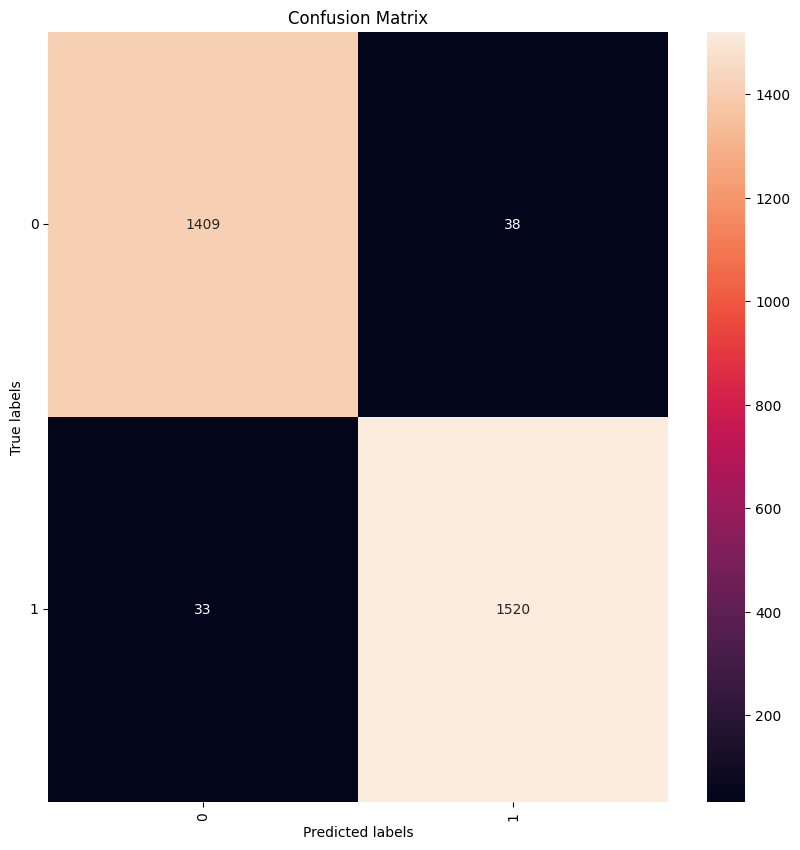

In [ ]:
trainer.run(train_loader, max_epochs=25) # LSTM 2 B

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 77.48 Сред. ошибка: 0.53393
Результат валидации - Эпоха: 1  Сред. точность: 75.00 Сред. ошибка: 0.54895


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 86.29 Сред. ошибка: 0.38758
Результат валидации - Эпоха: 2  Сред. точность: 84.03 Сред. ошибка: 0.41553


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 93.74 Сред. ошибка: 0.18262
Результат валидации - Эпоха: 3  Сред. точность: 91.23 Сред. ошибка: 0.23759


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 95.56 Сред. ошибка: 0.12280
Результат валидации - Эпоха: 4  Сред. точность: 92.67 Сред. ошибка: 0.19060


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 95.71 Сред. ошибка: 0.12466
Результат валидации - Эпоха: 5  Сред. точность: 92.87 Сред. ошибка: 0.20128


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.21 Сред. ошибка: 0.10176
Результат валидации - Эпоха: 6  Сред. точность: 93.23 Сред. ошибка: 0.18380


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 97.70 Сред. ошибка: 0.06204
Результат валидации - Эпоха: 7  Сред. точность: 94.83 Сред. ошибка: 0.14338


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 98.51 Сред. ошибка: 0.04478
Результат валидации - Эпоха: 8  Сред. точность: 95.60 Сред. ошибка: 0.14049


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.08 Сред. ошибка: 0.03042
Результат валидации - Эпоха: 9  Сред. точность: 96.00 Сред. ошибка: 0.15714


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 98.24 Сред. ошибка: 0.05181
Результат валидации - Эпоха: 10  Сред. точность: 94.67 Сред. ошибка: 0.20491


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 97.12 Сред. ошибка: 0.07025
Результат валидации - Эпоха: 11  Сред. точность: 94.07 Сред. ошибка: 0.15862


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 98.92 Сред. ошибка: 0.03016
Результат валидации - Эпоха: 12  Сред. точность: 95.93 Сред. ошибка: 0.14094


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.45 Сред. ошибка: 0.01666
Результат валидации - Эпоха: 13  Сред. точность: 96.47 Сред. ошибка: 0.14818


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.25 Сред. ошибка: 0.02402
Результат валидации - Эпоха: 14  Сред. точность: 95.93 Сред. ошибка: 0.17806


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.57 Сред. ошибка: 0.01140
Результат валидации - Эпоха: 15  Сред. точность: 96.23 Сред. ошибка: 0.15097


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.65 Сред. ошибка: 0.01174
Результат валидации - Эпоха: 16  Сред. точность: 96.17 Сред. ошибка: 0.18705


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.68 Сред. ошибка: 0.00823
Результат валидации - Эпоха: 17  Сред. точность: 96.37 Сред. ошибка: 0.15309


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.76 Сред. ошибка: 0.00631
Результат валидации - Эпоха: 18  Сред. точность: 96.67 Сред. ошибка: 0.16491


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.85 Сред. ошибка: 0.00481
Результат валидации - Эпоха: 19  Сред. точность: 96.70 Сред. ошибка: 0.17704


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.84 Сред. ошибка: 0.00523
Результат валидации - Эпоха: 20  Сред. точность: 96.77 Сред. ошибка: 0.19755


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.85 Сред. ошибка: 0.00527
Результат валидации - Эпоха: 21  Сред. точность: 96.37 Сред. ошибка: 0.22716


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.66 Сред. ошибка: 0.01347
Результат валидации - Эпоха: 22  Сред. точность: 97.20 Сред. ошибка: 0.17316


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.78 Сред. ошибка: 0.00737
Результат валидации - Эпоха: 23  Сред. точность: 97.30 Сред. ошибка: 0.17036


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.88 Сред. ошибка: 0.00324
Результат валидации - Эпоха: 24  Сред. точность: 97.10 Сред. ошибка: 0.17041


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.86 Сред. ошибка: 0.00294
Результат валидации - Эпоха: 25  Сред. точность: 96.77 Сред. ошибка: 0.18120


State:
	iteration: 6650
	epoch: 25
	epoch_length: 266
	max_epochs: 25
	output: 0.054990995675325394
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

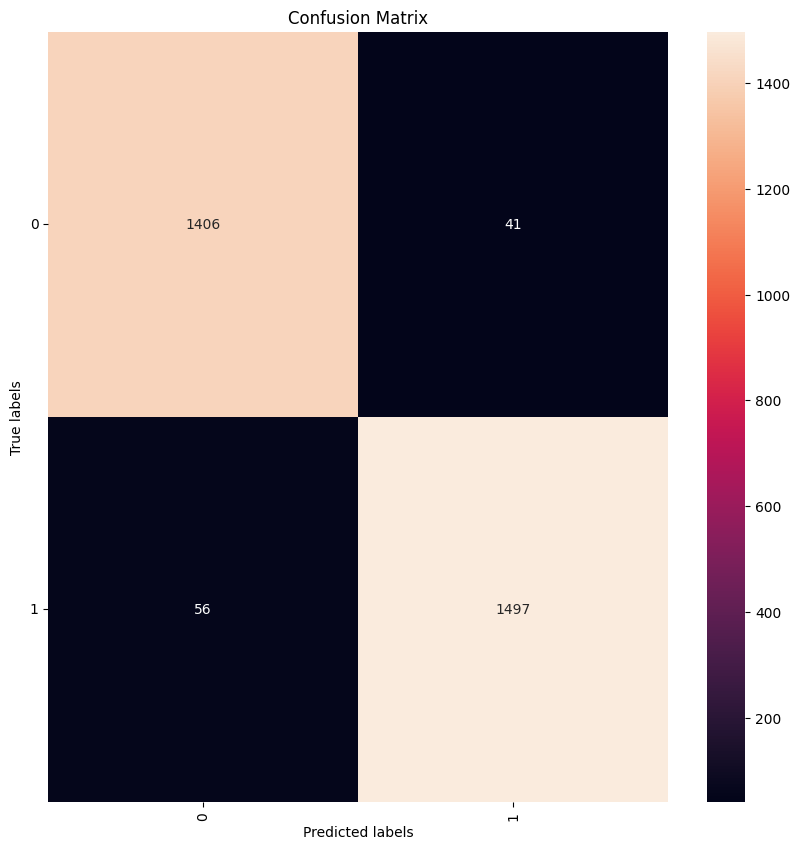

In [ ]:
trainer.run(train_loader, max_epochs=25) # LSTM 2 C

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 60.41 Сред. ошибка: 0.92283
Результат валидации - Эпоха: 1  Сред. точность: 58.93 Сред. ошибка: 0.96174


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 87.67 Сред. ошибка: 0.31252
Результат валидации - Эпоха: 2  Сред. точность: 86.10 Сред. ошибка: 0.34282


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 87.32 Сред. ошибка: 0.32978
Результат валидации - Эпоха: 3  Сред. точность: 86.73 Сред. ошибка: 0.34613


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 77.11 Сред. ошибка: 0.48816
Результат валидации - Эпоха: 4  Сред. точность: 75.47 Сред. ошибка: 0.51043


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 83.22 Сред. ошибка: 0.37699
Результат валидации - Эпоха: 5  Сред. точность: 81.13 Сред. ошибка: 0.41803


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 88.18 Сред. ошибка: 0.28946
Результат валидации - Эпоха: 6  Сред. точность: 84.90 Сред. ошибка: 0.35282


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 92.49 Сред. ошибка: 0.20203
Результат валидации - Эпоха: 7  Сред. точность: 88.70 Сред. ошибка: 0.29060


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 95.52 Сред. ошибка: 0.13220
Результат валидации - Эпоха: 8  Сред. точность: 91.63 Сред. ошибка: 0.24201


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 97.34 Сред. ошибка: 0.08757
Результат валидации - Эпоха: 9  Сред. точность: 93.27 Сред. ошибка: 0.20564


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 98.16 Сред. ошибка: 0.06436
Результат валидации - Эпоха: 10  Сред. точность: 93.97 Сред. ошибка: 0.19838


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 98.80 Сред. ошибка: 0.04560
Результат валидации - Эпоха: 11  Сред. точность: 94.73 Сред. ошибка: 0.18990


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.15 Сред. ошибка: 0.03656
Результат валидации - Эпоха: 12  Сред. точность: 95.47 Сред. ошибка: 0.18175


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.34 Сред. ошибка: 0.02937
Результат валидации - Эпоха: 13  Сред. точность: 95.37 Сред. ошибка: 0.18806


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.55 Сред. ошибка: 0.02224
Результат валидации - Эпоха: 14  Сред. точность: 95.60 Сред. ошибка: 0.18483


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 98.98 Сред. ошибка: 0.03491
Результат валидации - Эпоха: 15  Сред. точность: 94.93 Сред. ошибка: 0.21958


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.69 Сред. ошибка: 0.01578
Результат валидации - Эпоха: 16  Сред. точность: 95.80 Сред. ошибка: 0.18019


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.76 Сред. ошибка: 0.01511
Результат валидации - Эпоха: 17  Сред. точность: 95.83 Сред. ошибка: 0.18059


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 98.91 Сред. ошибка: 0.03672
Результат валидации - Эпоха: 18  Сред. точность: 94.90 Сред. ошибка: 0.21493


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.82 Сред. ошибка: 0.01112
Результат валидации - Эпоха: 19  Сред. точность: 96.07 Сред. ошибка: 0.18679


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.81 Сред. ошибка: 0.01142
Результат валидации - Эпоха: 20  Сред. точность: 96.10 Сред. ошибка: 0.18998


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.88 Сред. ошибка: 0.00838
Результат валидации - Эпоха: 21  Сред. точность: 96.00 Сред. ошибка: 0.19597


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.77 Сред. ошибка: 0.01152
Результат валидации - Эпоха: 22  Сред. точность: 96.07 Сред. ошибка: 0.19815


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.87 Сред. ошибка: 0.00808
Результат валидации - Эпоха: 23  Сред. точность: 96.30 Сред. ошибка: 0.19615


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.88 Сред. ошибка: 0.00720
Результат валидации - Эпоха: 24  Сред. точность: 96.23 Сред. ошибка: 0.18829


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.90 Сред. ошибка: 0.00571
Результат валидации - Эпоха: 25  Сред. точность: 96.30 Сред. ошибка: 0.20342


State:
	iteration: 6650
	epoch: 25
	epoch_length: 266
	max_epochs: 25
	output: 0.00047258552513085306
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

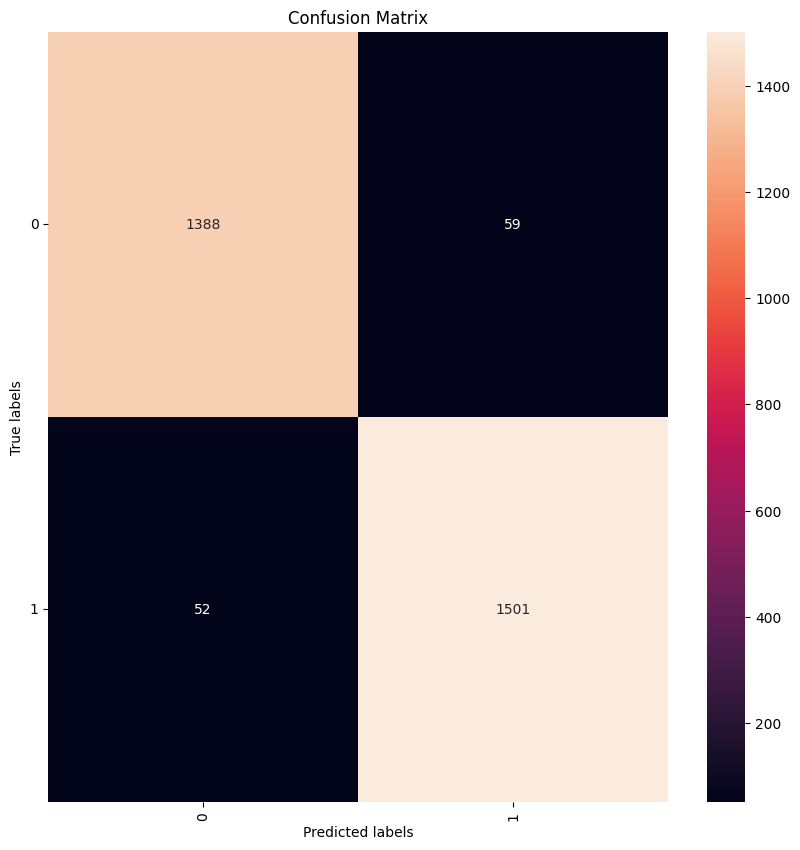

In [ ]:
trainer.run(train_loader, max_epochs=25) # GRU 1 A

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 88.74 Сред. ошибка: 0.34942
Результат валидации - Эпоха: 1  Сред. точность: 86.27 Сред. ошибка: 0.38525


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 92.31 Сред. ошибка: 0.24626
Результат валидации - Эпоха: 2  Сред. точность: 90.57 Сред. ошибка: 0.27353


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 95.90 Сред. ошибка: 0.13844
Результат валидации - Эпоха: 3  Сред. точность: 94.43 Сред. ошибка: 0.18304


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 96.66 Сред. ошибка: 0.11587
Результат валидации - Эпоха: 4  Сред. точность: 94.63 Сред. ошибка: 0.17811


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 95.21 Сред. ошибка: 0.14015
Результат валидации - Эпоха: 5  Сред. точность: 92.40 Сред. ошибка: 0.21154


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 97.82 Сред. ошибка: 0.07623
Результат валидации - Эпоха: 6  Сред. точность: 95.43 Сред. ошибка: 0.14154


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 98.32 Сред. ошибка: 0.06206
Результат валидации - Эпоха: 7  Сред. точность: 96.77 Сред. ошибка: 0.12369


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 98.73 Сред. ошибка: 0.04435
Результат валидации - Эпоха: 8  Сред. точность: 95.83 Сред. ошибка: 0.13394


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.12 Сред. ошибка: 0.03403
Результат валидации - Эпоха: 9  Сред. точность: 97.20 Сред. ошибка: 0.11220


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.58 Сред. ошибка: 0.01973
Результат валидации - Эпоха: 10  Сред. точность: 97.27 Сред. ошибка: 0.10622


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.49 Сред. ошибка: 0.02135
Результат валидации - Эпоха: 11  Сред. точность: 96.70 Сред. ошибка: 0.11776


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.75 Сред. ошибка: 0.01120
Результат валидации - Эпоха: 12  Сред. точность: 97.23 Сред. ошибка: 0.11686


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.77 Сред. ошибка: 0.01084
Результат валидации - Эпоха: 13  Сред. точность: 97.53 Сред. ошибка: 0.11975


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.64 Сред. ошибка: 0.01426
Результат валидации - Эпоха: 14  Сред. точность: 97.03 Сред. ошибка: 0.11776


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.84 Сред. ошибка: 0.00757
Результат валидации - Эпоха: 15  Сред. точность: 97.33 Сред. ошибка: 0.12068


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.91 Сред. ошибка: 0.00420
Результат валидации - Эпоха: 16  Сред. точность: 97.53 Сред. ошибка: 0.12019


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.92 Сред. ошибка: 0.00361
Результат валидации - Эпоха: 17  Сред. точность: 97.83 Сред. ошибка: 0.11484


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.95 Сред. ошибка: 0.00238
Результат валидации - Эпоха: 18  Сред. точность: 97.57 Сред. ошибка: 0.12715


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.90 Сред. ошибка: 0.00327
Результат валидации - Эпоха: 19  Сред. точность: 97.67 Сред. ошибка: 0.11566


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.98 Сред. ошибка: 0.00106
Результат валидации - Эпоха: 20  Сред. точность: 97.67 Сред. ошибка: 0.12508


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.44 Сред. ошибка: 0.02439
Результат валидации - Эпоха: 21  Сред. точность: 97.30 Сред. ошибка: 0.13917


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.95 Сред. ошибка: 0.00173
Результат валидации - Эпоха: 22  Сред. точность: 97.90 Сред. ошибка: 0.10368


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.98 Сред. ошибка: 0.00091
Результат валидации - Эпоха: 23  Сред. точность: 98.20 Сред. ошибка: 0.10837


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.92 Сред. ошибка: 0.00243
Результат валидации - Эпоха: 24  Сред. точность: 98.23 Сред. ошибка: 0.10276


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.99 Сред. ошибка: 0.00060
Результат валидации - Эпоха: 25  Сред. точность: 97.83 Сред. ошибка: 0.12354


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 26  Сред. точность: 100.00 Сред. ошибка: 0.00025
Результат валидации - Эпоха: 26  Сред. точность: 98.13 Сред. ошибка: 0.12250


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 27  Сред. точность: 99.62 Сред. ошибка: 0.01546
Результат валидации - Эпоха: 27  Сред. точность: 97.30 Сред. ошибка: 0.17022


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 28  Сред. точность: 99.96 Сред. ошибка: 0.00141
Результат валидации - Эпоха: 28  Сред. точность: 98.17 Сред. ошибка: 0.09440


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 29  Сред. точность: 99.99 Сред. ошибка: 0.00031
Результат валидации - Эпоха: 29  Сред. точность: 98.27 Сред. ошибка: 0.11186


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 30  Сред. точность: 99.99 Сред. ошибка: 0.00011
Результат валидации - Эпоха: 30  Сред. точность: 98.40 Сред. ошибка: 0.11716


State:
	iteration: 7980
	epoch: 30
	epoch_length: 266
	max_epochs: 30
	output: 3.2837306207511574e-05
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

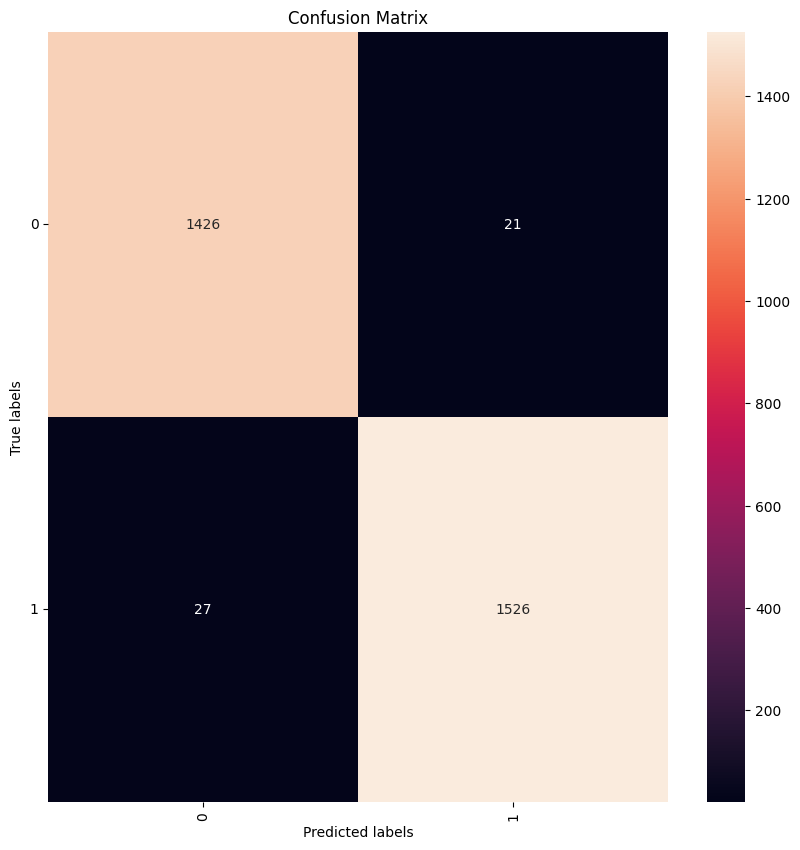

In [ ]:
trainer.run(train_loader, max_epochs=30) # GRU 1 B

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 53.40 Сред. ошибка: 0.63885
Результат валидации - Эпоха: 1  Сред. точность: 50.77 Сред. ошибка: 0.65161


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 94.88 Сред. ошибка: 0.16612
Результат валидации - Эпоха: 2  Сред. точность: 92.43 Сред. ошибка: 0.22934


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 96.68 Сред. ошибка: 0.11480
Результат валидации - Эпоха: 3  Сред. точность: 94.33 Сред. ошибка: 0.18586


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 80.49 Сред. ошибка: 0.44343
Результат валидации - Эпоха: 4  Сред. точность: 79.43 Сред. ошибка: 0.46570


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 95.94 Сред. ошибка: 0.13696
Результат валидации - Эпоха: 5  Сред. точность: 93.23 Сред. ошибка: 0.23904


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 90.62 Сред. ошибка: 0.23638
Результат валидации - Эпоха: 6  Сред. точность: 87.83 Сред. ошибка: 0.29464


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 98.17 Сред. ошибка: 0.06449
Результат валидации - Эпоха: 7  Сред. точность: 96.57 Сред. ошибка: 0.13164


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 98.78 Сред. ошибка: 0.04621
Результат валидации - Эпоха: 8  Сред. точность: 96.40 Сред. ошибка: 0.13413


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 99.28 Сред. ошибка: 0.02921
Результат валидации - Эпоха: 9  Сред. точность: 97.13 Сред. ошибка: 0.11816


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.58 Сред. ошибка: 0.01928
Результат валидации - Эпоха: 10  Сред. точность: 97.27 Сред. ошибка: 0.11567


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.02 Сред. ошибка: 0.03232
Результат валидации - Эпоха: 11  Сред. точность: 96.90 Сред. ошибка: 0.11359


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.59 Сред. ошибка: 0.01566
Результат валидации - Эпоха: 12  Сред. точность: 97.57 Сред. ошибка: 0.11300


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.81 Сред. ошибка: 0.00972
Результат валидации - Эпоха: 13  Сред. точность: 97.40 Сред. ошибка: 0.12689


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.73 Сред. ошибка: 0.01010
Результат валидации - Эпоха: 14  Сред. точность: 96.73 Сред. ошибка: 0.14263


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.89 Сред. ошибка: 0.00534
Результат валидации - Эпоха: 15  Сред. точность: 97.53 Сред. ошибка: 0.12373


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.91 Сред. ошибка: 0.00410
Результат валидации - Эпоха: 16  Сред. точность: 97.53 Сред. ошибка: 0.13405


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.73 Сред. ошибка: 0.01057
Результат валидации - Эпоха: 17  Сред. точность: 97.17 Сред. ошибка: 0.13322


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.91 Сред. ошибка: 0.00353
Результат валидации - Эпоха: 18  Сред. точность: 97.60 Сред. ошибка: 0.12530


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.96 Сред. ошибка: 0.00225
Результат валидации - Эпоха: 19  Сред. точность: 97.47 Сред. ошибка: 0.13027


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.95 Сред. ошибка: 0.00224
Результат валидации - Эпоха: 20  Сред. точность: 97.90 Сред. ошибка: 0.12021


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.92 Сред. ошибка: 0.00357
Результат валидации - Эпоха: 21  Сред. точность: 97.17 Сред. ошибка: 0.13865


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.64 Сред. ошибка: 0.01246
Результат валидации - Эпоха: 22  Сред. точность: 97.17 Сред. ошибка: 0.11613


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.93 Сред. ошибка: 0.00253
Результат валидации - Эпоха: 23  Сред. точность: 97.50 Сред. ошибка: 0.10953


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.98 Сред. ошибка: 0.00089
Результат валидации - Эпоха: 24  Сред. точность: 97.77 Сред. ошибка: 0.12426


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.98 Сред. ошибка: 0.00050
Результат валидации - Эпоха: 25  Сред. точность: 97.93 Сред. ошибка: 0.12972


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 26  Сред. точность: 99.95 Сред. ошибка: 0.00192
Результат валидации - Эпоха: 26  Сред. точность: 98.20 Сред. ошибка: 0.13029


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 27  Сред. точность: 99.95 Сред. ошибка: 0.00188
Результат валидации - Эпоха: 27  Сред. точность: 97.73 Сред. ошибка: 0.12061


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 28  Сред. точность: 99.98 Сред. ошибка: 0.00081
Результат валидации - Эпоха: 28  Сред. точность: 97.90 Сред. ошибка: 0.12713


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 29  Сред. точность: 99.23 Сред. ошибка: 0.03152
Результат валидации - Эпоха: 29  Сред. точность: 96.87 Сред. ошибка: 0.22582


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 30  Сред. точность: 100.00 Сред. ошибка: 0.00009
Результат валидации - Эпоха: 30  Сред. точность: 97.87 Сред. ошибка: 0.14039


State:
	iteration: 7980
	epoch: 30
	epoch_length: 266
	max_epochs: 30
	output: 0.00016923988005146384
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

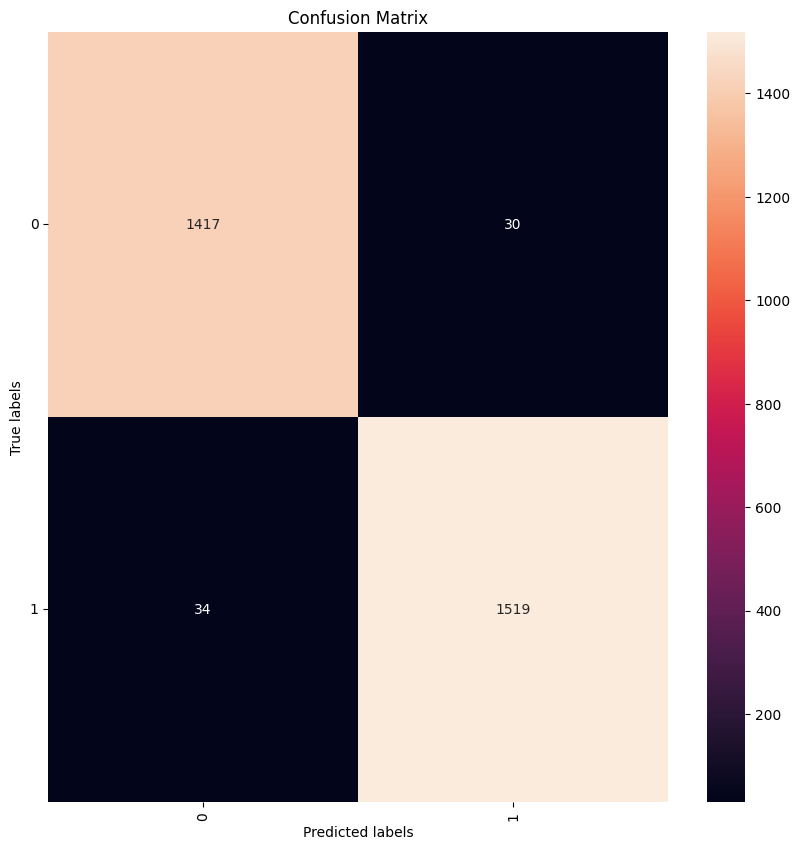

In [ ]:
trainer.run(train_loader, max_epochs=30) # GRU 1 C

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 85.07 Сред. ошибка: 0.40169
Результат валидации - Эпоха: 1  Сред. точность: 85.03 Сред. ошибка: 0.39915


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 86.21 Сред. ошибка: 0.32899
Результат валидации - Эпоха: 2  Сред. точность: 83.40 Сред. ошибка: 0.36736


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 96.01 Сред. ошибка: 0.13182
Результат валидации - Эпоха: 3  Сред. точность: 94.27 Сред. ошибка: 0.18431


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 97.46 Сред. ошибка: 0.08588
Результат валидации - Эпоха: 4  Сред. точность: 95.33 Сред. ошибка: 0.16315


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 97.31 Сред. ошибка: 0.09114
Результат валидации - Эпоха: 5  Сред. точность: 94.97 Сред. ошибка: 0.17409


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 98.78 Сред. ошибка: 0.04427
Результат валидации - Эпоха: 6  Сред. точность: 96.50 Сред. ошибка: 0.13657


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 96.68 Сред. ошибка: 0.12250
Результат валидации - Эпоха: 7  Сред. точность: 94.63 Сред. ошибка: 0.23958


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 99.32 Сред. ошибка: 0.02789
Результат валидации - Эпоха: 8  Сред. точность: 97.23 Сред. ошибка: 0.14831


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 98.55 Сред. ошибка: 0.05447
Результат валидации - Эпоха: 9  Сред. точность: 96.13 Сред. ошибка: 0.19826


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 99.54 Сред. ошибка: 0.01647
Результат валидации - Эпоха: 10  Сред. точность: 97.50 Сред. ошибка: 0.11775


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.13 Сред. ошибка: 0.02714
Результат валидации - Эпоха: 11  Сред. точность: 96.77 Сред. ошибка: 0.12258


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.68 Сред. ошибка: 0.01153
Результат валидации - Эпоха: 12  Сред. точность: 97.40 Сред. ошибка: 0.13334


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.82 Сред. ошибка: 0.00797
Результат валидации - Эпоха: 13  Сред. точность: 97.87 Сред. ошибка: 0.15048


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.89 Сред. ошибка: 0.00397
Результат валидации - Эпоха: 14  Сред. точность: 97.97 Сред. ошибка: 0.15845


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.94 Сред. ошибка: 0.00481
Результат валидации - Эпоха: 15  Сред. точность: 97.77 Сред. ошибка: 0.19628


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.86 Сред. ошибка: 0.00528
Результат валидации - Эпоха: 16  Сред. точность: 97.50 Сред. ошибка: 0.20274


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.78 Сред. ошибка: 0.00678
Результат валидации - Эпоха: 17  Сред. точность: 97.20 Сред. ошибка: 0.19614


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.87 Сред. ошибка: 0.00407
Результат валидации - Эпоха: 18  Сред. точность: 97.30 Сред. ошибка: 0.18341


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.92 Сред. ошибка: 0.00461
Результат валидации - Эпоха: 19  Сред. точность: 97.27 Сред. ошибка: 0.21794


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.98 Сред. ошибка: 0.00084
Результат валидации - Эпоха: 20  Сред. точность: 97.83 Сред. ошибка: 0.25059


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.99 Сред. ошибка: 0.00033
Результат валидации - Эпоха: 21  Сред. точность: 97.60 Сред. ошибка: 0.24209


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.81 Сред. ошибка: 0.01087
Результат валидации - Эпоха: 22  Сред. точность: 97.47 Сред. ошибка: 0.20424


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.99 Сред. ошибка: 0.00060
Результат валидации - Эпоха: 23  Сред. точность: 97.83 Сред. ошибка: 0.23211


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.99 Сред. ошибка: 0.00041


2025-04-14 02:15:09,329 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации - Эпоха: 24  Сред. точность: 97.73 Сред. ошибка: 0.24396


2025-04-14 02:15:09,826 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


State:
	iteration: 6384
	epoch: 24
	epoch_length: 266
	max_epochs: 30
	output: 0.01164981722831726
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

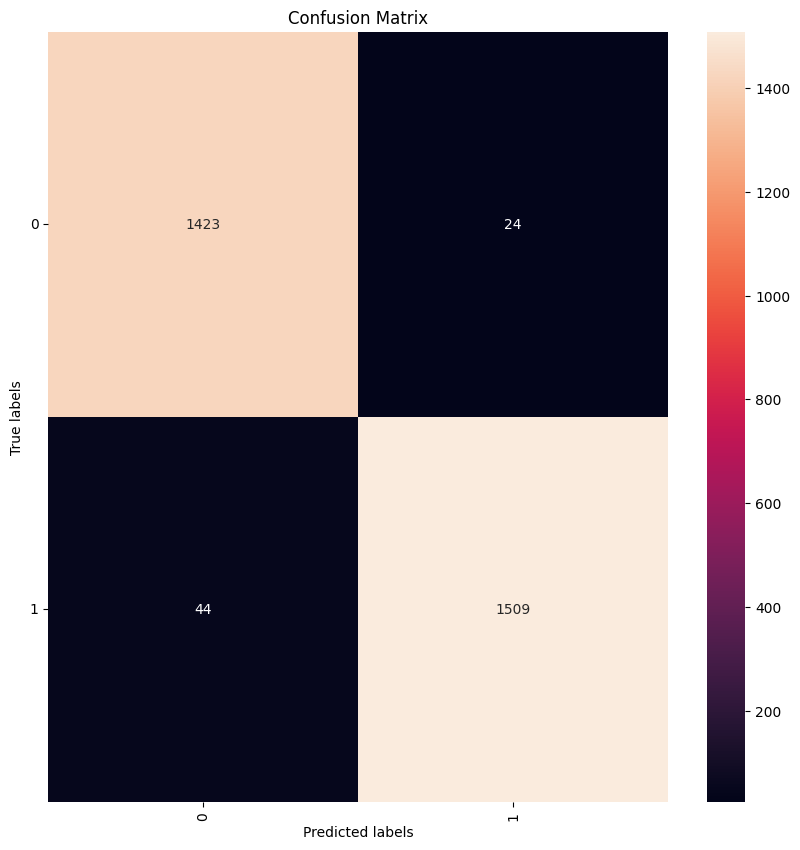

In [ ]:
trainer.run(train_loader, max_epochs=30) # GRU 2 A

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 57.10 Сред. ошибка: 0.68292
Результат валидации - Эпоха: 1  Сред. точность: 58.10 Сред. ошибка: 0.68247


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 79.85 Сред. ошибка: 0.47778
Результат валидации - Эпоха: 2  Сред. точность: 80.10 Сред. ошибка: 0.47453


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 93.84 Сред. ошибка: 0.19928
Результат валидации - Эпоха: 3  Сред. точность: 91.67 Сред. ошибка: 0.24170


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 95.04 Сред. ошибка: 0.18489
Результат валидации - Эпоха: 4  Сред. точность: 93.23 Сред. ошибка: 0.23471


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 95.34 Сред. ошибка: 0.15687
Результат валидации - Эпоха: 5  Сред. точность: 92.57 Сред. ошибка: 0.22621


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.74 Сред. ошибка: 0.11950
Результат валидации - Эпоха: 6  Сред. точность: 93.30 Сред. ошибка: 0.21382


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 96.86 Сред. ошибка: 0.11367
Результат валидации - Эпоха: 7  Сред. точность: 94.77 Сред. ошибка: 0.18683


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 97.84 Сред. ошибка: 0.07754
Результат валидации - Эпоха: 8  Сред. точность: 95.30 Сред. ошибка: 0.16305


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 98.28 Сред. ошибка: 0.06860
Результат валидации - Эпоха: 9  Сред. точность: 95.50 Сред. ошибка: 0.17516


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 98.32 Сред. ошибка: 0.06258
Результат валидации - Эпоха: 10  Сред. точность: 95.00 Сред. ошибка: 0.18661


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 99.09 Сред. ошибка: 0.03972
Результат валидации - Эпоха: 11  Сред. точность: 96.53 Сред. ошибка: 0.15454


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.21 Сред. ошибка: 0.03313
Результат валидации - Эпоха: 12  Сред. точность: 96.37 Сред. ошибка: 0.15796


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.24 Сред. ошибка: 0.02937
Результат валидации - Эпоха: 13  Сред. точность: 96.33 Сред. ошибка: 0.16036


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.31 Сред. ошибка: 0.02750
Результат валидации - Эпоха: 14  Сред. точность: 97.07 Сред. ошибка: 0.13409


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.62 Сред. ошибка: 0.01715
Результат валидации - Эпоха: 15  Сред. точность: 97.07 Сред. ошибка: 0.15268


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 97.81 Сред. ошибка: 0.06639
Результат валидации - Эпоха: 16  Сред. точность: 94.70 Сред. ошибка: 0.17683


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 99.47 Сред. ошибка: 0.02207
Результат валидации - Эпоха: 17  Сред. точность: 96.97 Сред. ошибка: 0.16209


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.68 Сред. ошибка: 0.01620
Результат валидации - Эпоха: 18  Сред. точность: 96.83 Сред. ошибка: 0.18071


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.64 Сред. ошибка: 0.01490
Результат валидации - Эпоха: 19  Сред. точность: 96.97 Сред. ошибка: 0.17713


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.76 Сред. ошибка: 0.01197
Результат валидации - Эпоха: 20  Сред. точность: 97.20 Сред. ошибка: 0.20342


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.64 Сред. ошибка: 0.01785
Результат валидации - Эпоха: 21  Сред. точность: 97.07 Сред. ошибка: 0.20798


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.24 Сред. ошибка: 0.02814
Результат валидации - Эпоха: 22  Сред. точность: 96.10 Сред. ошибка: 0.20197


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.57 Сред. ошибка: 0.01934
Результат валидации - Эпоха: 23  Сред. точность: 97.00 Сред. ошибка: 0.17179


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.82 Сред. ошибка: 0.00848
Результат валидации - Эпоха: 24  Сред. точность: 96.83 Сред. ошибка: 0.18452


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.88 Сред. ошибка: 0.00664
Результат валидации - Эпоха: 25  Сред. точность: 97.33 Сред. ошибка: 0.21197


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 26  Сред. точность: 96.54 Сред. ошибка: 0.09390
Результат валидации - Эпоха: 26  Сред. точность: 92.43 Сред. ошибка: 0.22644


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 27  Сред. точность: 99.09 Сред. ошибка: 0.03163
Результат валидации - Эпоха: 27  Сред. точность: 95.97 Сред. ошибка: 0.18682


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 28  Сред. точность: 99.66 Сред. ошибка: 0.01196
Результат валидации - Эпоха: 28  Сред. точность: 96.87 Сред. ошибка: 0.20290


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 29  Сред. точность: 99.81 Сред. ошибка: 0.00666
Результат валидации - Эпоха: 29  Сред. точность: 96.80 Сред. ошибка: 0.22856


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 30  Сред. точность: 99.91 Сред. ошибка: 0.00429
Результат валидации - Эпоха: 30  Сред. точность: 96.93 Сред. ошибка: 0.25628


State:
	iteration: 7980
	epoch: 30
	epoch_length: 266
	max_epochs: 30
	output: 0.009314765222370625
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

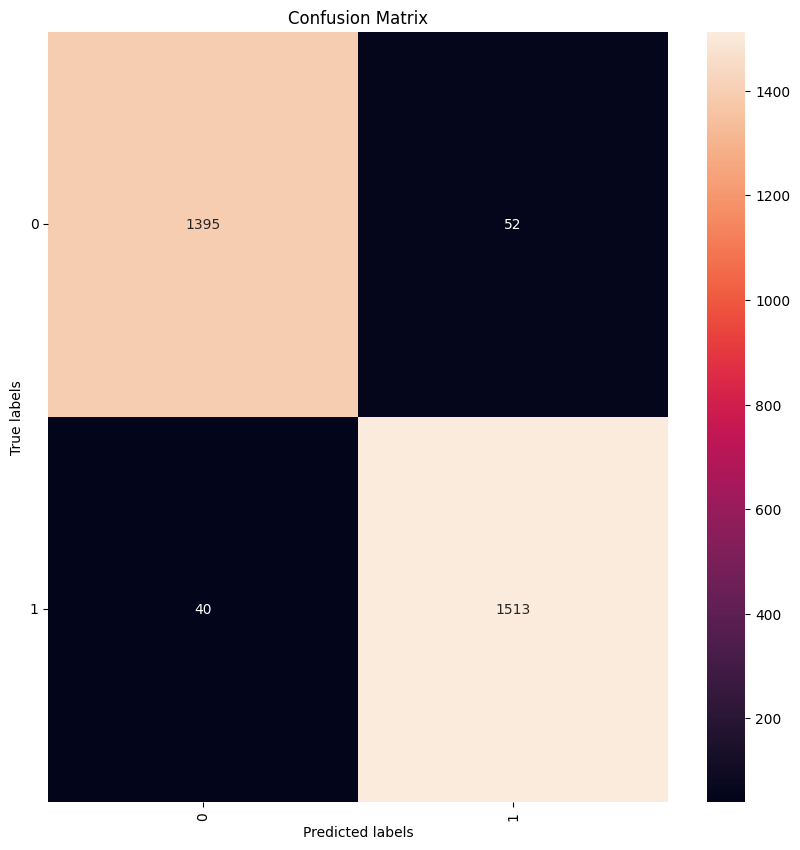

In [ ]:
trainer.run(train_loader, max_epochs=30) # GRU 2 B

  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 50.31 Сред. ошибка: 0.69227
Результат валидации - Эпоха: 1  Сред. точность: 48.23 Сред. ошибка: 0.69376


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 72.72 Сред. ошибка: 0.59565
Результат валидации - Эпоха: 2  Сред. точность: 70.80 Сред. ошибка: 0.60274


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 89.14 Сред. ошибка: 0.28514
Результат валидации - Эпоха: 3  Сред. точность: 87.03 Сред. ошибка: 0.32217


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 86.89 Сред. ошибка: 0.31806
Результат валидации - Эпоха: 4  Сред. точность: 85.37 Сред. ошибка: 0.34918


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 94.00 Сред. ошибка: 0.17643
Результат валидации - Эпоха: 5  Сред. точность: 92.23 Сред. ошибка: 0.22532


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 96.64 Сред. ошибка: 0.12609
Результат валидации - Эпоха: 6  Сред. точность: 94.03 Сред. ошибка: 0.20658


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 97.12 Сред. ошибка: 0.11888
Результат валидации - Эпоха: 7  Сред. точность: 94.13 Сред. ошибка: 0.24149


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 96.05 Сред. ошибка: 0.12683
Результат валидации - Эпоха: 8  Сред. точность: 93.27 Сред. ошибка: 0.21873


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 97.79 Сред. ошибка: 0.07452
Результат валидации - Эпоха: 9  Сред. точность: 95.20 Сред. ошибка: 0.17200


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 98.50 Сред. ошибка: 0.06157
Результат валидации - Эпоха: 10  Сред. точность: 96.00 Сред. ошибка: 0.17376


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 98.77 Сред. ошибка: 0.04857
Результат валидации - Эпоха: 11  Сред. точность: 96.17 Сред. ошибка: 0.16822


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 99.14 Сред. ошибка: 0.04379
Результат валидации - Эпоха: 12  Сред. точность: 96.30 Сред. ошибка: 0.17986


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 99.06 Сред. ошибка: 0.04181
Результат валидации - Эпоха: 13  Сред. точность: 96.33 Сред. ошибка: 0.16418


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 99.18 Сред. ошибка: 0.03708
Результат валидации - Эпоха: 14  Сред. точность: 96.80 Сред. ошибка: 0.16883


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 99.42 Сред. ошибка: 0.03259
Результат валидации - Эпоха: 15  Сред. точность: 96.87 Сред. ошибка: 0.19059


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 99.46 Сред. ошибка: 0.03163
Результат валидации - Эпоха: 16  Сред. точность: 96.67 Сред. ошибка: 0.19059


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 98.92 Сред. ошибка: 0.04305
Результат валидации - Эпоха: 17  Сред. точность: 96.30 Сред. ошибка: 0.14640


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 99.29 Сред. ошибка: 0.03014
Результат валидации - Эпоха: 18  Сред. точность: 96.60 Сред. ошибка: 0.14688


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 99.57 Сред. ошибка: 0.02003
Результат валидации - Эпоха: 19  Сред. точность: 97.00 Сред. ошибка: 0.15403


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 99.75 Сред. ошибка: 0.01524
Результат валидации - Эпоха: 20  Сред. точность: 97.10 Сред. ошибка: 0.20732


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 99.74 Сред. ошибка: 0.01456
Результат валидации - Эпоха: 21  Сред. точность: 97.10 Сред. ошибка: 0.18278


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 99.74 Сред. ошибка: 0.01338
Результат валидации - Эпоха: 22  Сред. точность: 96.97 Сред. ошибка: 0.20399


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 99.76 Сред. ошибка: 0.01358
Результат валидации - Эпоха: 23  Сред. точность: 97.30 Сред. ошибка: 0.17429


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 99.81 Сред. ошибка: 0.01103
Результат валидации - Эпоха: 24  Сред. точность: 97.33 Сред. ошибка: 0.19240


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 99.66 Сред. ошибка: 0.01716
Результат валидации - Эпоха: 25  Сред. точность: 96.87 Сред. ошибка: 0.19166


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 26  Сред. точность: 99.78 Сред. ошибка: 0.01189
Результат валидации - Эпоха: 26  Сред. точность: 97.33 Сред. ошибка: 0.21523


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 27  Сред. точность: 99.25 Сред. ошибка: 0.03471
Результат валидации - Эпоха: 27  Сред. точность: 96.33 Сред. ошибка: 0.17928


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 28  Сред. точность: 99.63 Сред. ошибка: 0.01703
Результат валидации - Эпоха: 28  Сред. точность: 96.83 Сред. ошибка: 0.17583


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 29  Сред. точность: 99.82 Сред. ошибка: 0.01029
Результат валидации - Эпоха: 29  Сред. точность: 97.07 Сред. ошибка: 0.21156


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 30  Сред. точность: 99.85 Сред. ошибка: 0.00754
Результат валидации - Эпоха: 30  Сред. точность: 97.27 Сред. ошибка: 0.22427


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 31  Сред. точность: 99.90 Сред. ошибка: 0.00578
Результат валидации - Эпоха: 31  Сред. точность: 97.33 Сред. ошибка: 0.24849


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 32  Сред. точность: 99.91 Сред. ошибка: 0.00441
Результат валидации - Эпоха: 32  Сред. точность: 97.47 Сред. ошибка: 0.20981


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 33  Сред. точность: 99.92 Сред. ошибка: 0.00394
Результат валидации - Эпоха: 33  Сред. точность: 97.40 Сред. ошибка: 0.20313


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 34  Сред. точность: 99.95 Сред. ошибка: 0.00298
Результат валидации - Эпоха: 34  Сред. точность: 97.40 Сред. ошибка: 0.29531


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 35  Сред. точность: 99.96 Сред. ошибка: 0.00261
Результат валидации - Эпоха: 35  Сред. точность: 97.43 Сред. ошибка: 0.28474


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 36  Сред. точность: 99.92 Сред. ошибка: 0.00372
Результат валидации - Эпоха: 36  Сред. точность: 97.27 Сред. ошибка: 0.26125


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 37  Сред. точность: 99.95 Сред. ошибка: 0.00367
Результат валидации - Эпоха: 37  Сред. точность: 97.33 Сред. ошибка: 0.27503


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 38  Сред. точность: 99.93 Сред. ошибка: 0.00253
Результат валидации - Эпоха: 38  Сред. точность: 97.20 Сред. ошибка: 0.23400


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 39  Сред. точность: 99.96 Сред. ошибка: 0.00205
Результат валидации - Эпоха: 39  Сред. точность: 97.40 Сред. ошибка: 0.22778


  0%|          | 1/266 [00:00<?, ?it/s]

Результат обучения - Эпоха: 40  Сред. точность: 99.97 Сред. ошибка: 0.00150
Результат валидации - Эпоха: 40  Сред. точность: 97.33 Сред. ошибка: 0.22196


State:
	iteration: 10640
	epoch: 40
	epoch_length: 266
	max_epochs: 40
	output: 0.015215528197586536
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

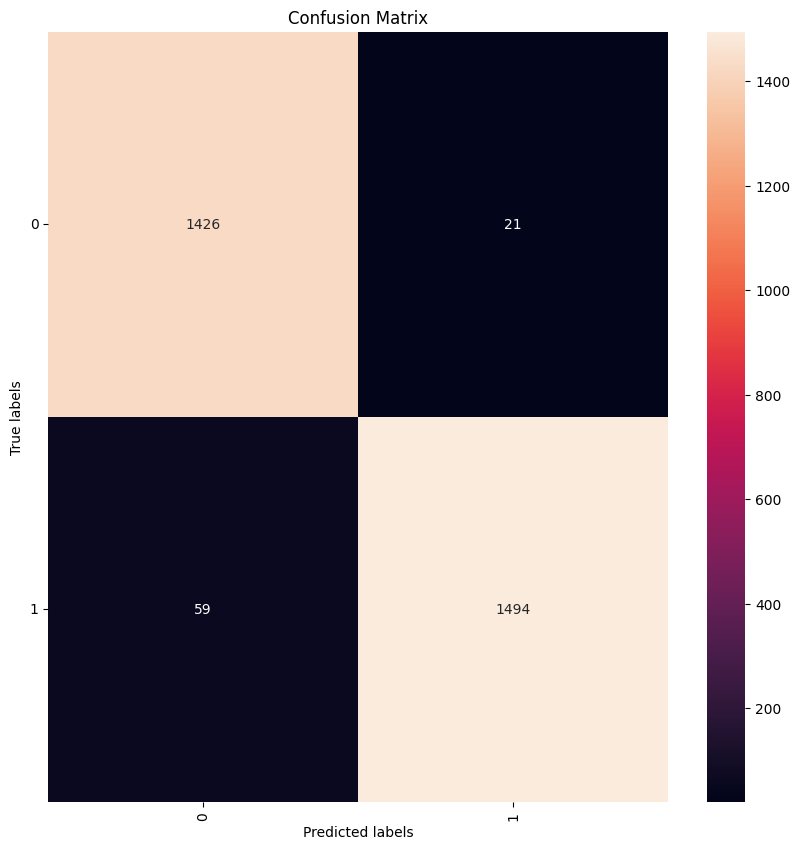

In [ ]:
trainer.run(train_loader, max_epochs=40) # GRU 2 C

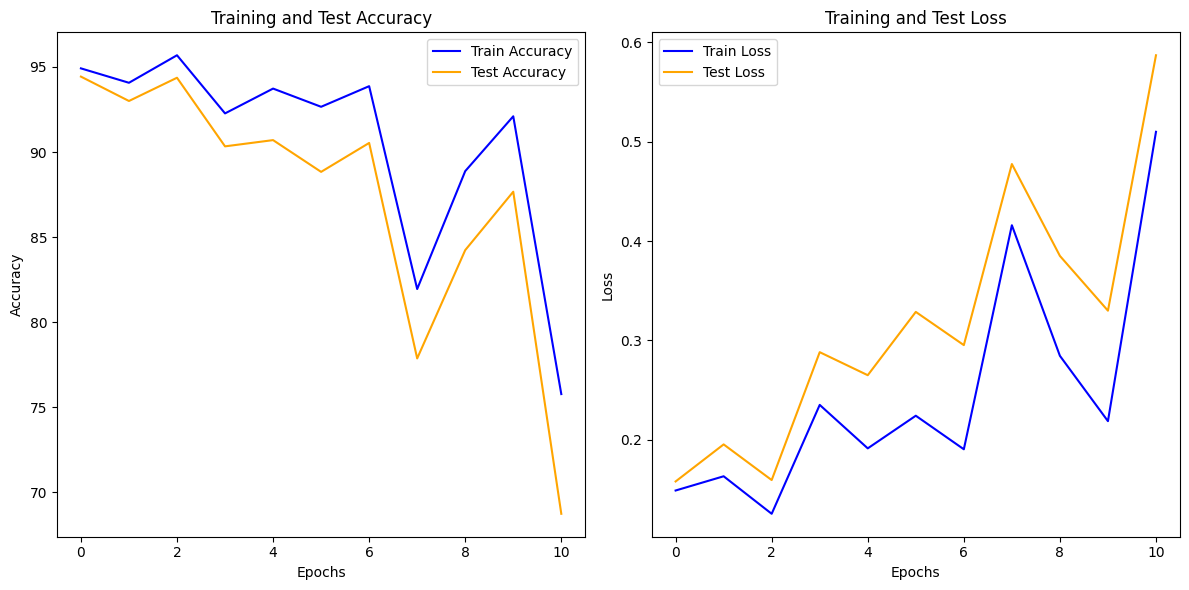

In [ ]:
epochs = list(range(len(last_epoch)))  # rnn1a

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

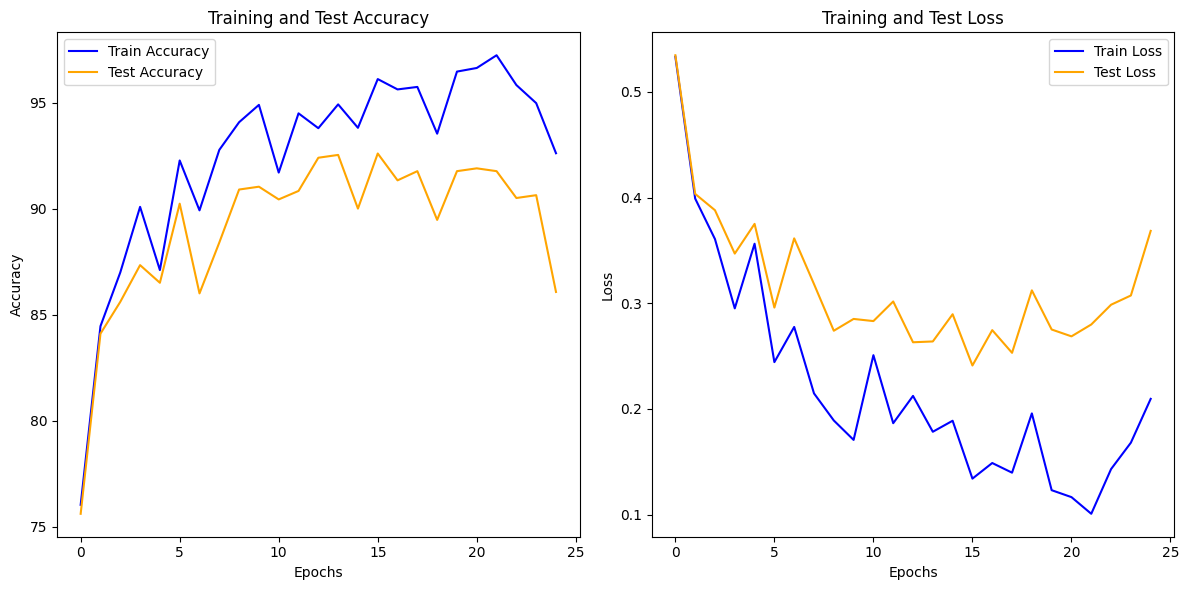

In [ ]:
epochs = list(range(len(last_epoch)))  # rnn1b

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

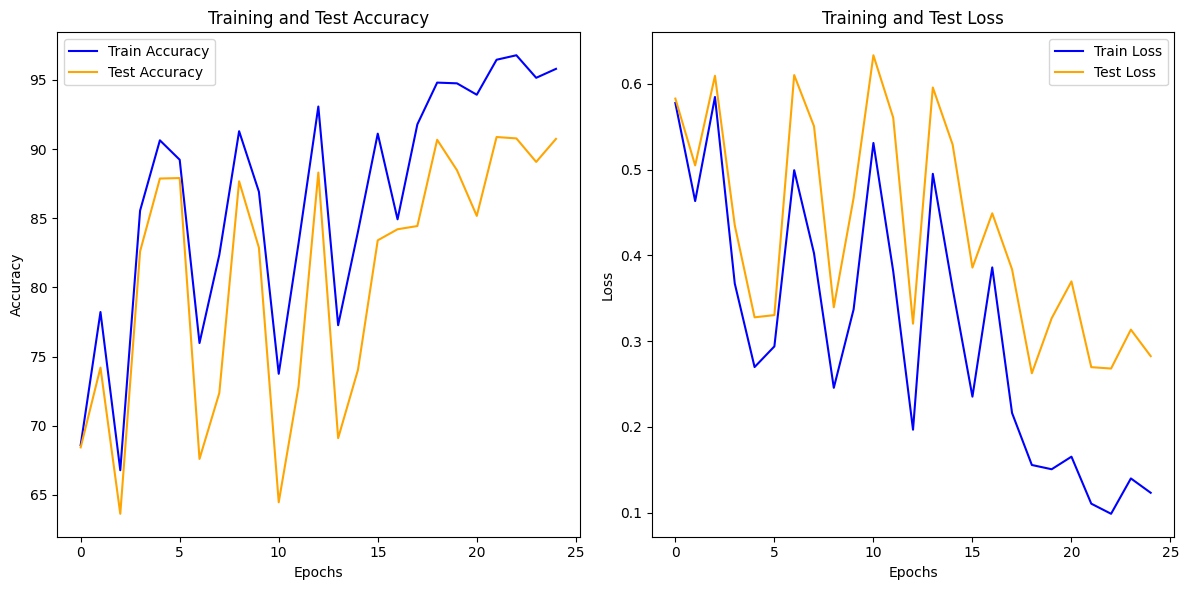

In [ ]:
epochs = list(range(len(last_epoch)))  # rnn1c

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

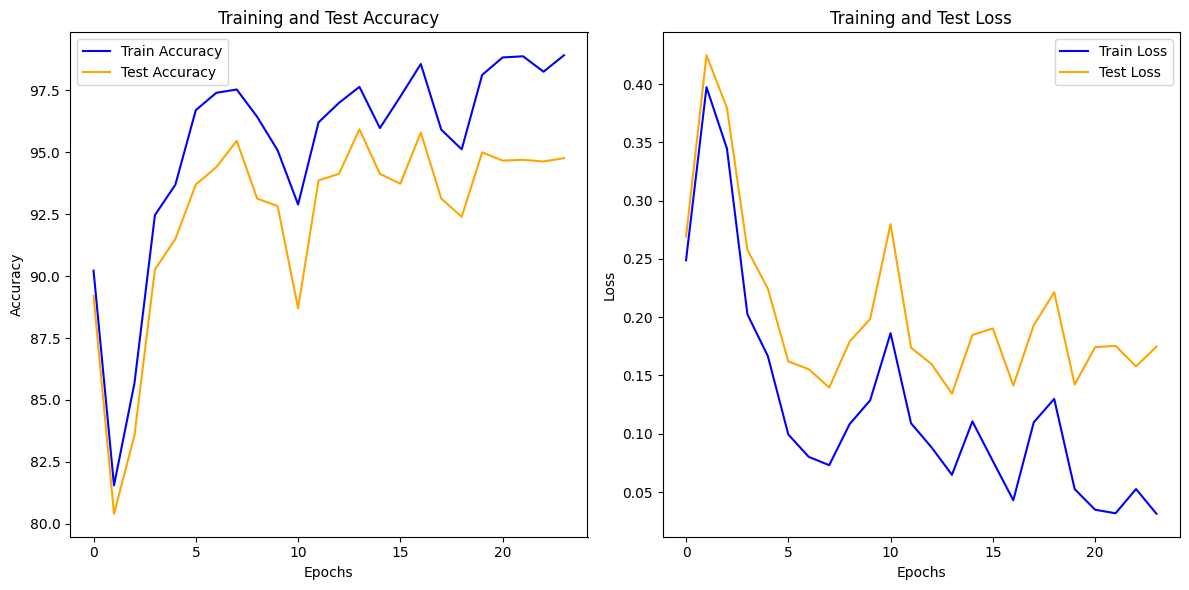

In [ ]:
epochs = list(range(len(last_epoch)))  # rnn2a

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

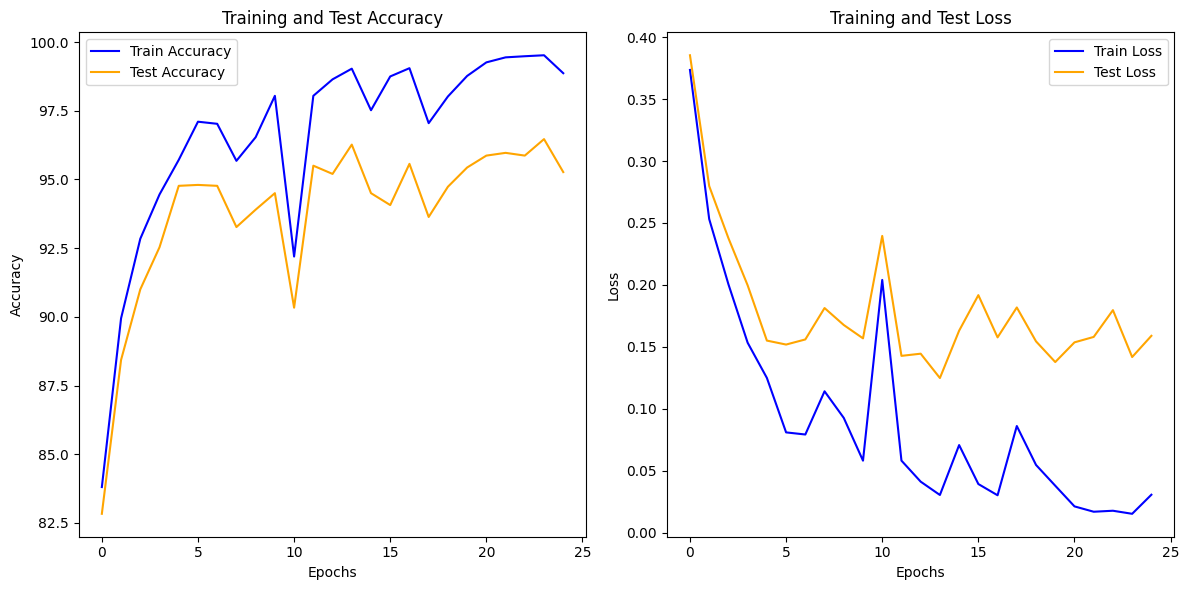

In [ ]:
epochs = list(range(len(last_epoch)))  # rnn2b

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

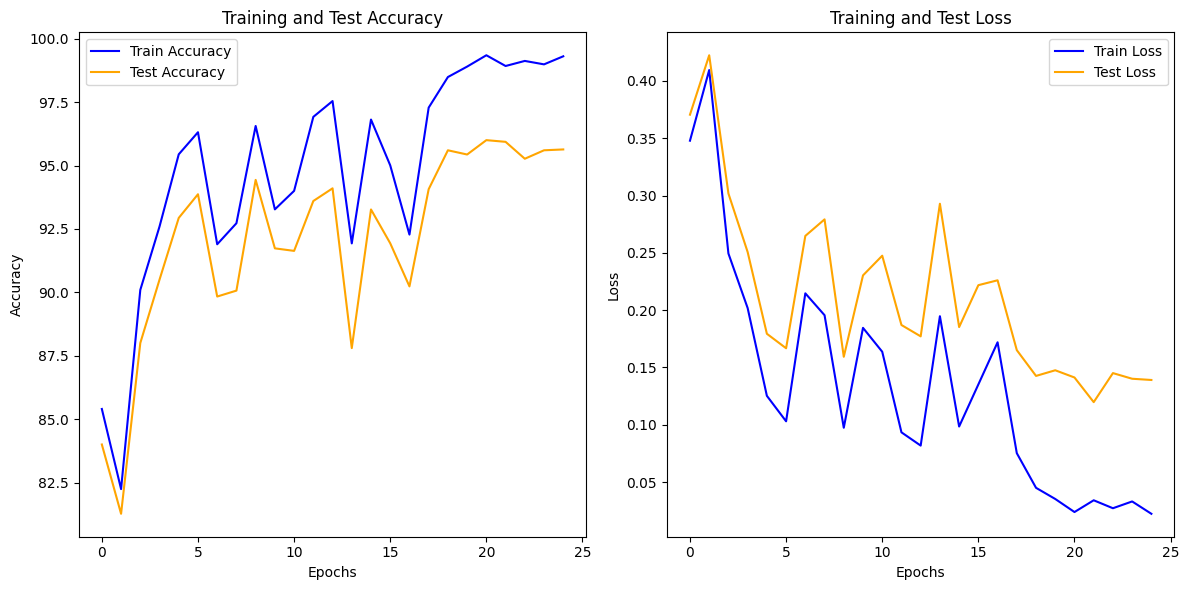

In [ ]:
epochs = list(range(len(last_epoch)))  # rnn2c

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

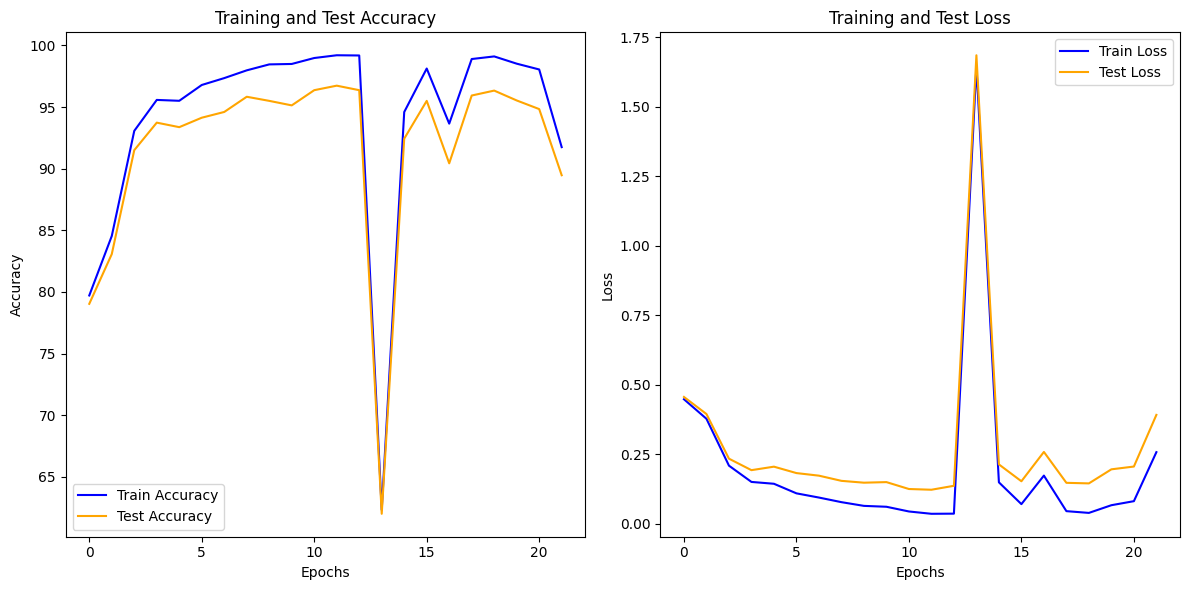

In [ ]:
epochs = list(range(len(last_epoch)))  # lstm1a

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

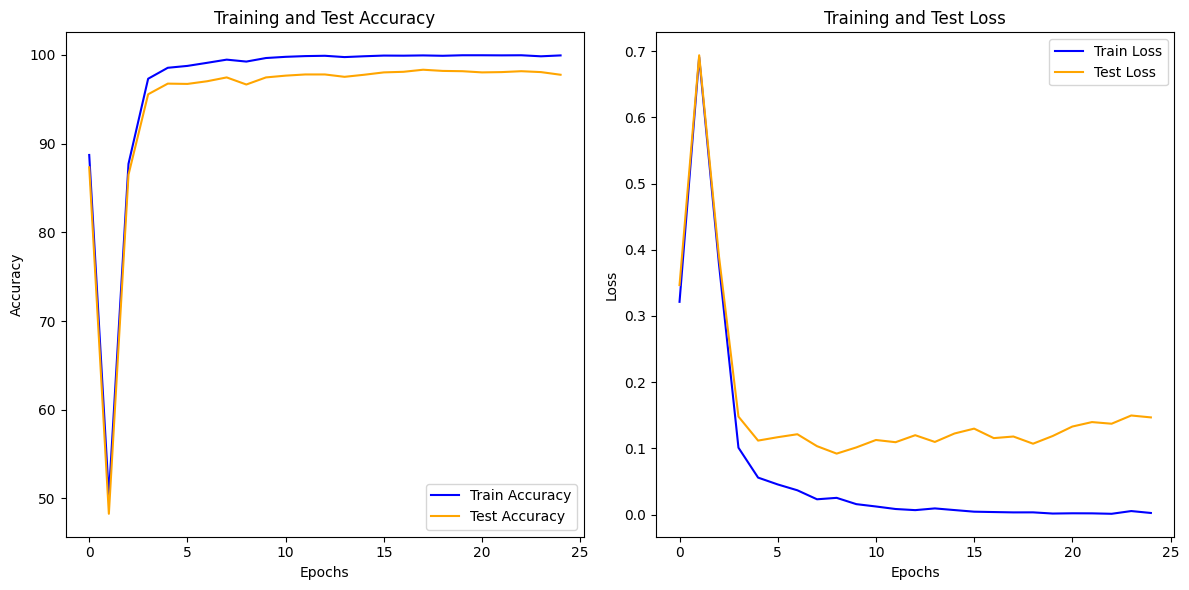

In [ ]:
epochs = list(range(len(last_epoch)))  # lstm1b

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

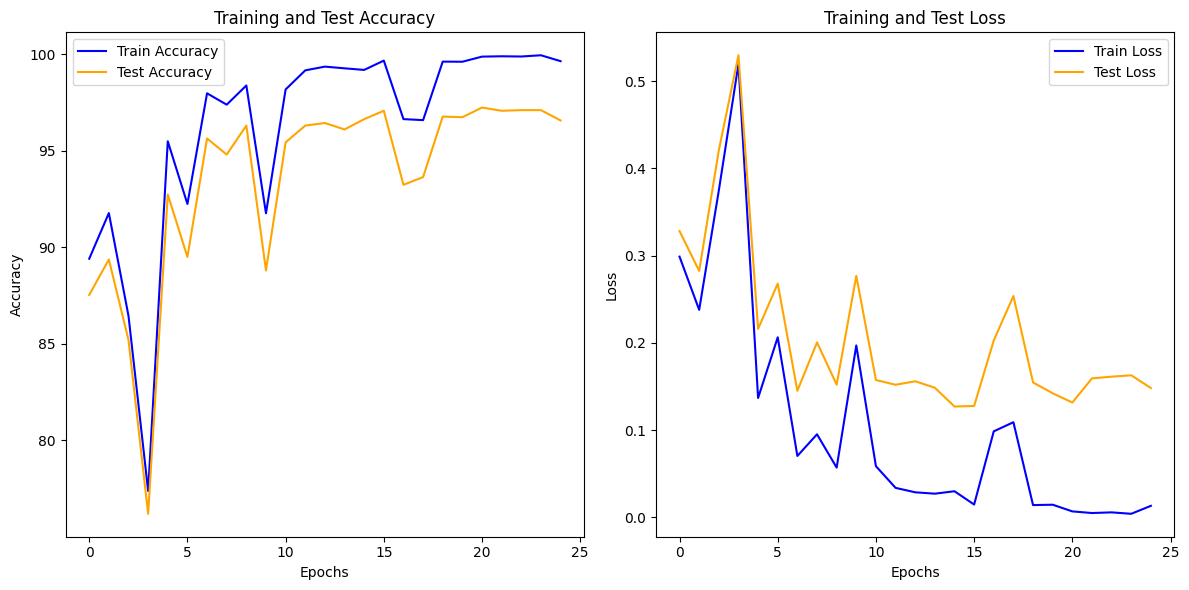

In [ ]:
epochs = list(range(len(last_epoch)))  # lstm1c

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

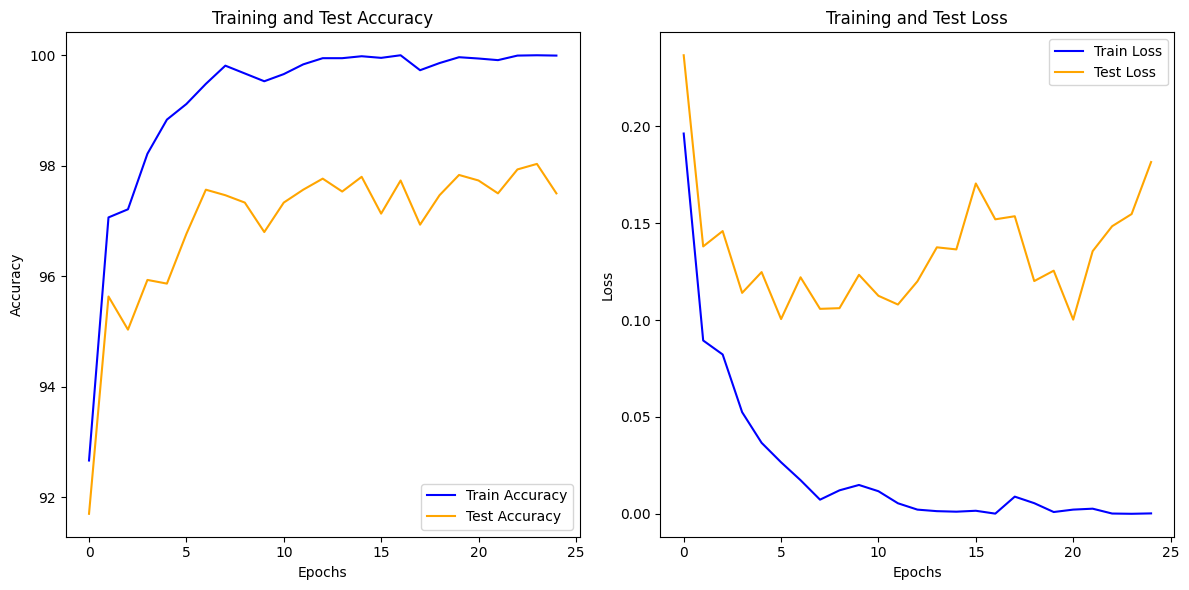

In [ ]:
epochs = list(range(len(last_epoch)))  # lstm2a

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

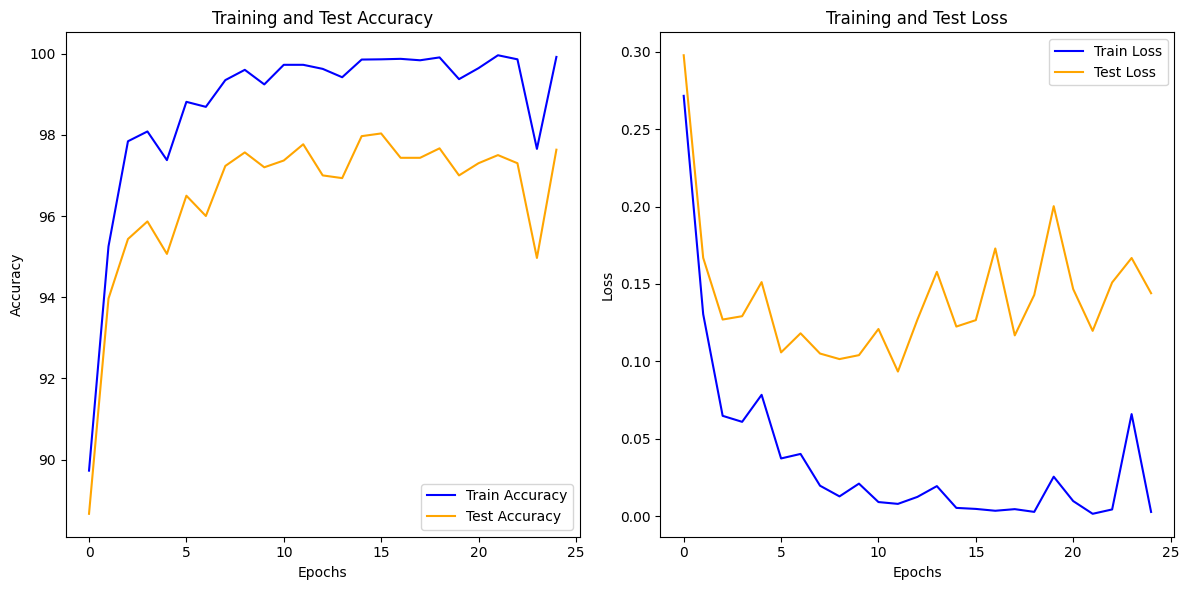

In [ ]:
epochs = list(range(len(last_epoch)))  # lstm2b

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

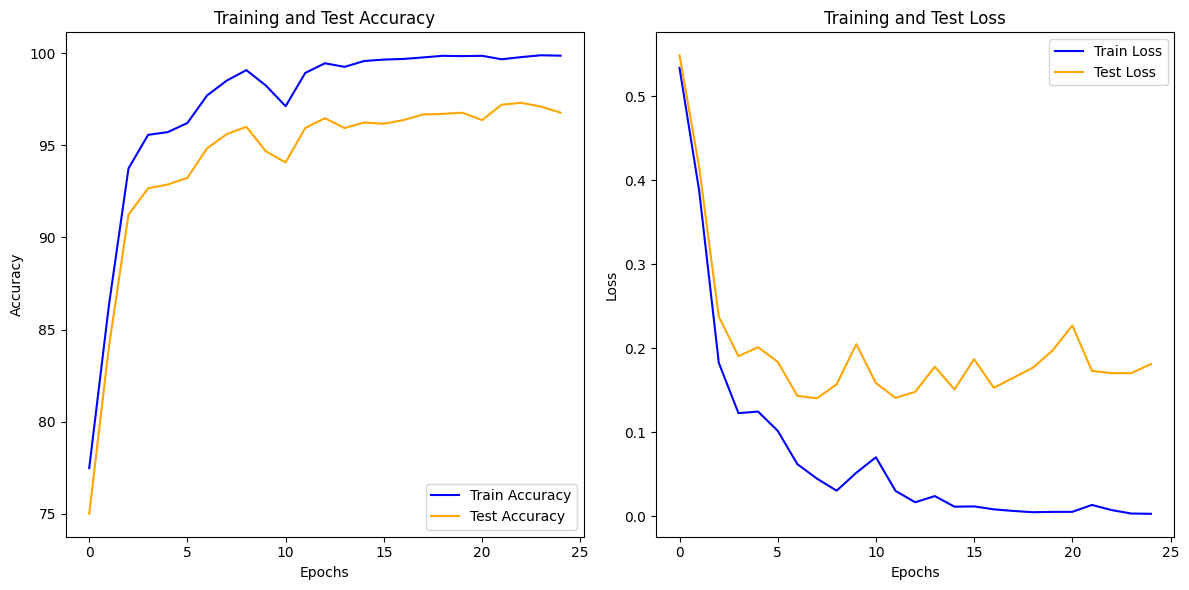

In [ ]:
epochs = list(range(len(last_epoch)))  # lstm2c

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

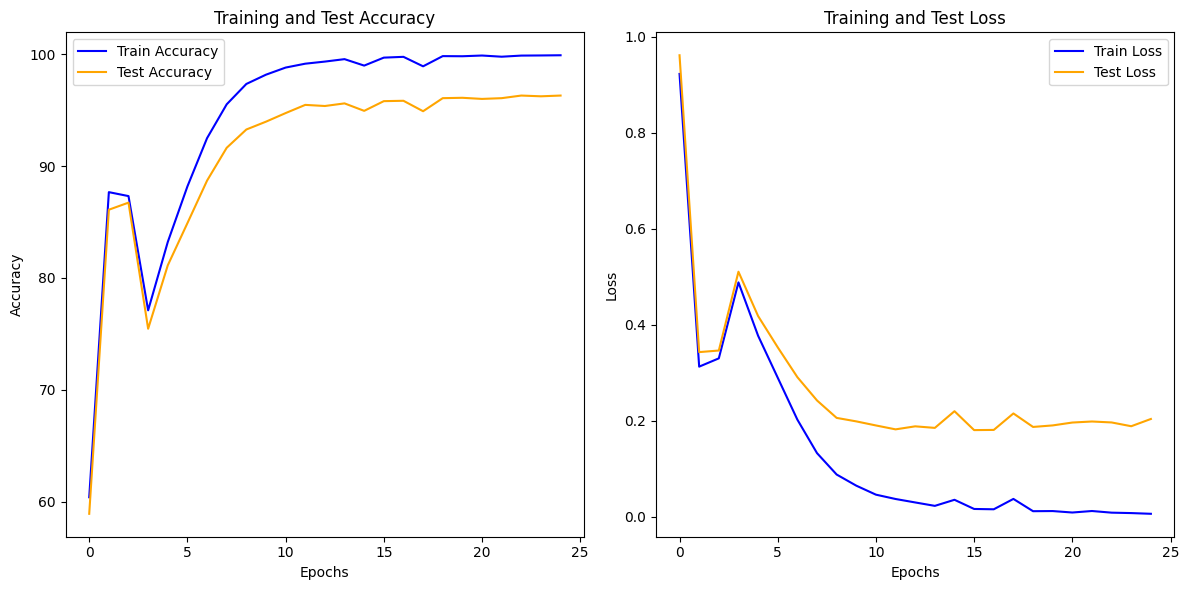

In [ ]:
epochs = list(range(len(last_epoch)))  # gru1a

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

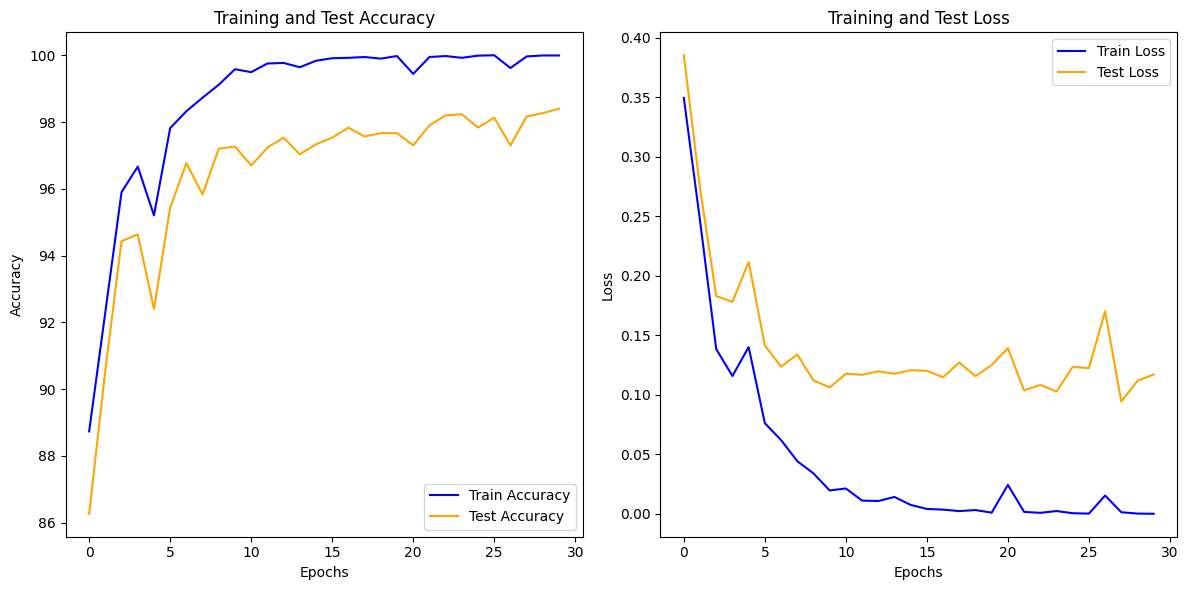

In [ ]:
epochs = list(range(len(last_epoch)))  # gru1b

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

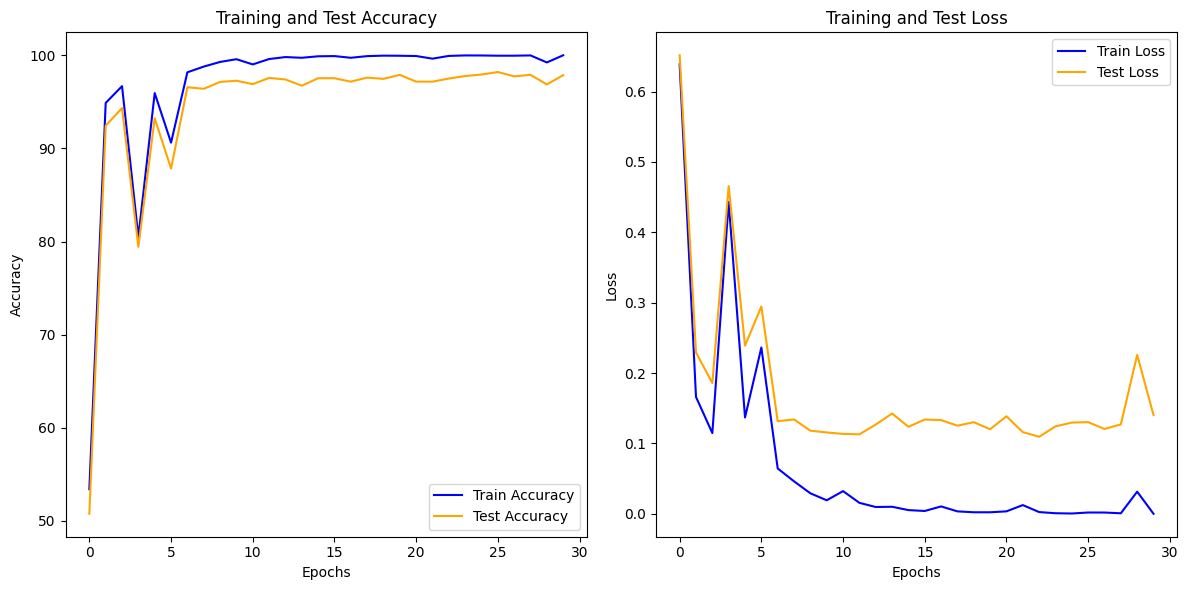

In [ ]:
epochs = list(range(len(last_epoch)))  # gru1c

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

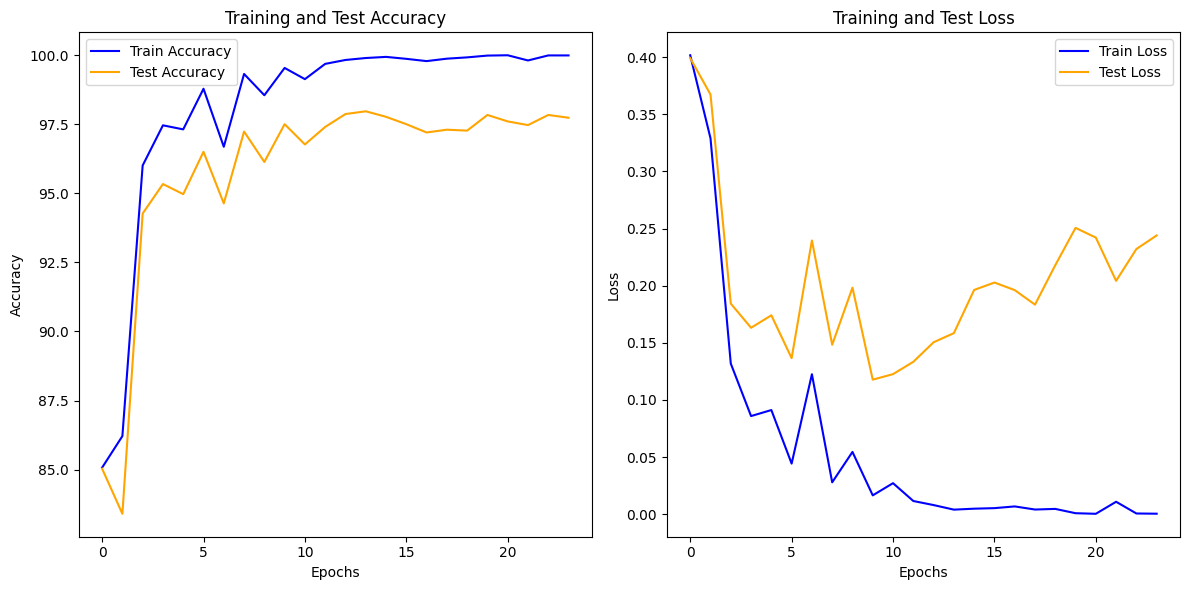

In [ ]:
epochs = list(range(len(last_epoch)))  # gru2a

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

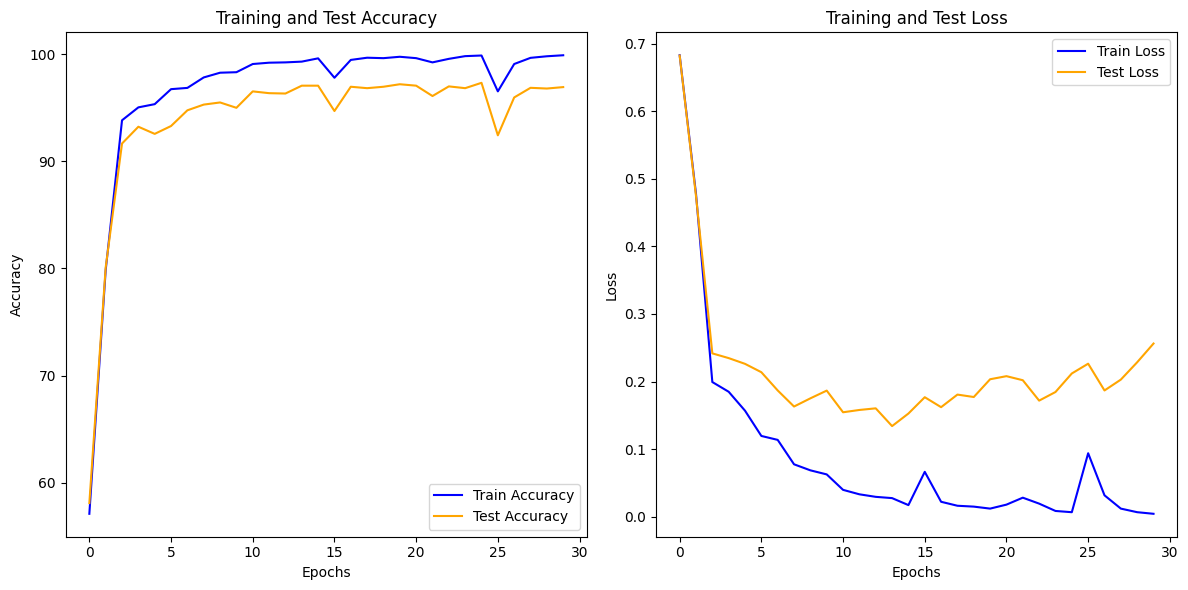

In [ ]:
epochs = list(range(len(last_epoch)))  # gru2b

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

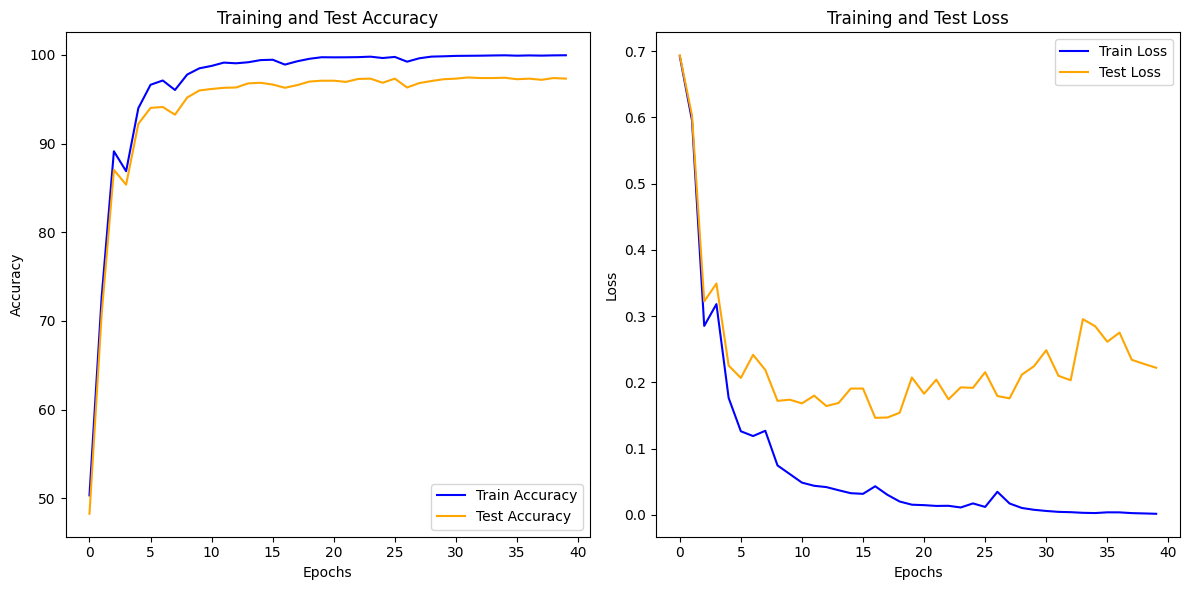

In [ ]:
epochs = list(range(len(last_epoch)))  # gru2с

# Построение графика точности
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Подграфик для точности
plt.plot(epochs, training_history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(epochs, test_history['accuracy'], label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

# Построение графика потери
plt.subplot(1, 2, 2)  # Подграфик для потери
plt.plot(epochs, training_history['loss'], label='Train Loss', color='blue')
plt.plot(epochs, test_history['loss'], label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

In [ ]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))

<All keys matched successfully>

In [ ]:
def get_preds(model, loader, device):
  model.eval()
  y_true = torch.tensor([], dtype=torch.long, device=device)
  all_outputs = torch.tensor([], device=device)

  with torch.no_grad():
      for data in test_loader:
          inputs = [i.to(device) for i in data[:-1]]
          labels = data[-1].to(device)

          outputs = model(*inputs)
          y_true = torch.cat((y_true, labels), 0)
          all_outputs = torch.cat((all_outputs, outputs), 0)

      y_true = y_true.cpu().numpy()
      _, y_pred = torch.max(all_outputs, 1)
      y_pred = y_pred.cpu().numpy()
      y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()

  return y_true, y_pred, y_pred_prob

In [ ]:
def get_preds(model, loader, device):
    model.eval()
    y_true = torch.tensor([], dtype=torch.long, device=device)
    all_outputs = torch.tensor([], device=device)

    with torch.no_grad():
        for data in loader:
            inputs_raw, labels = data
            inputs = [i.to(device) if isinstance(i, torch.Tensor) else torch.tensor(i, device=device) for i in inputs_raw]
            labels = labels.to(device)

            outputs = model(inputs)
            y_true = torch.cat((y_true, labels), 0)
            all_outputs = torch.cat((all_outputs, outputs), 0)

        y_true = y_true.cpu().numpy()
        _, y_pred = torch.max(all_outputs, 1)
        y_pred = y_pred.cpu().numpy()
        y_pred_prob = F.softmax(all_outputs, dim=1).cpu().numpy()

    return y_true, y_pred, y_pred_prob


In [ ]:
y_true, y_pred, _ = get_preds(model, test_loader, device)

In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # rnn1a

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1469
           1       0.95      0.94      0.95      1531

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # rnn1b

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1469
           1       0.93      0.93      0.93      1531

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # rnn1с

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1469
           1       0.91      0.91      0.91      1531

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # rnn2a

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1469
           1       0.97      0.95      0.96      1531

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # rnn2b

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1469
           1       0.97      0.96      0.97      1531

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # rnn2c

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1469
           1       0.96      0.97      0.96      1531

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # lstm1a

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1469
           1       0.97      0.96      0.97      1531

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # lstm1b

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1447
           1       0.99      0.98      0.98      1553

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # lstm1c

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1447
           1       0.97      0.97      0.97      1553

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # lstm2a

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1447
           1       0.98      0.98      0.98      1553

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # lstm2b

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1447
           1       0.99      0.97      0.98      1553

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # lstm2c

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1447
           1       0.98      0.97      0.97      1553

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # gru1a

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1447
           1       0.96      0.97      0.96      1553

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # gru1b

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1447
           1       0.99      0.98      0.98      1553

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # gru1c

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1447
           1       0.99      0.98      0.98      1553

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # gru2a

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1447
           1       0.98      0.98      0.98      1553

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # gru2b

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1447
           1       0.98      0.97      0.97      1553

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [ ]:
print(classification_report(y_true, y_pred, target_names=[str(c) for c in dataset.classes])) # gru2b

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1447
           1       0.98      0.97      0.98      1553

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



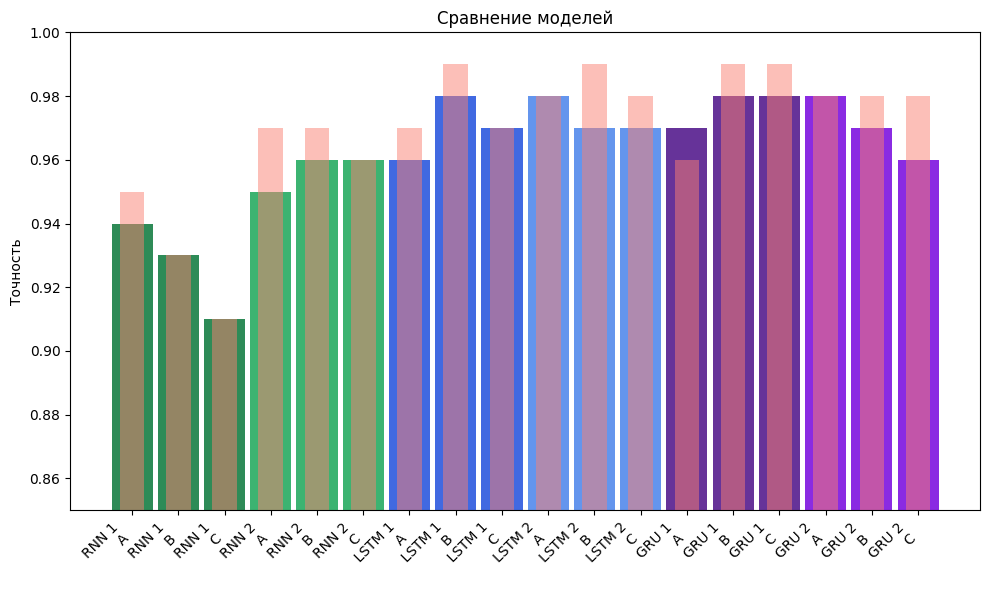

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Данные
groups = ['RNN 1', 'RNN 2', ' LSTM 1', 'LSTM 2', 'GRU 1', 'GRU 2']
subcategories = ['A', 'B', 'C']
data_fact = [
    [0.94, 0.93, 0.91],
    [0.95, 0.96, 0.96],
    [0.96, 0.98, 0.97],
    [0.98, 0.97, 0.97],
    [0.97, 0.98, 0.98],
    [0.98, 0.97, 0.96],
]
data_plan = [
    [0.95, 0.93, 0.91],
    [0.97, 0.97, 0.96],
    [0.97, 0.99, 0.97],
    [0.98, 0.99, 0.98],
    [0.96, 0.99, 0.99],
    [0.98, 0.98, 0.98],
]

group_colors = ['seagreen', 'mediumseagreen', 'royalblue', 'cornflowerblue', 'rebeccapurple', 'blueviolet']

bar_width = 0.4
spacing = 0.05
fig, ax = plt.subplots(figsize=(10, 6))

x_labels = []
x_pos = []

current_x = 0
for i in range(len(groups)):
    for j in range(len(subcategories)):
        label = f'{groups[i]}\n{subcategories[j]}'
        x_labels.append(label)
        x = current_x
        x_pos.append(x)

        # Первый параметр — "факт"
        ax.bar(x, data_fact[i][j], color=group_colors[i], width=bar_width, label='Факт' if i == 0 and j == 0 else "")

        # Второй параметр — "план", полупрозрачный, внахлёст
        ax.bar(x, data_plan[i][j], color='salmon', width=bar_width * 0.6, alpha=0.5, label='План' if i == 0 and j == 0 else "")

        current_x += bar_width + spacing

# Настройка подписей
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.set_ylabel('Точность')
ax.set_title('Сравнение моделей')
ax.set_ylim(0.85, 1.0)

# Легенда (однократное добавление)
# ax.legend()

plt.tight_layout()
plt.show()
